                                            Sales Forecasting Using Time Series Models

Project Objective
The project aims to forecast monthly sales using historical sales data from a superstore. By comparing multiple forecasting techniques, the project identifies the best-performing model to predict future sales trends, enabling better inventory planning, marketing strategies, and resource allocation.



Dataset:
The dataset used in this project is the **Superstore Sales Dataset** sourced from **Kaggle**. It contains transactional data from a retail store, including sales figures across multiple regions, products, and categories. The dataset includes the following key columns:

- **Order ID**: Unique identifier for each transaction.
- **Order Date**: The date on which the order was placed.
- **Ship Date**: The date on which the order was shipped.
- **Sales**: The monetary value of the sales.
- **Quantity**: The number of items purchased.
- **Discount**: The discount applied to the sales.
- **Profit**: The profit generated from the sale.
- **Region**: The geographical region where the sale was made.
- **Product Category**: The category of the product sold.
- **Customer ID**: Identifier for the customer who made the purchase.

For the purpose of this project, we focused primarily on the **Order Date** and **Sales** columns. The goal was to analyze daily sales data, identify seasonal patterns, and forecast future sales based on historical trends.

Workflow Steps

1. Data Loading and Preparation
 
    1.1 install required libraries

    1.2 Load Superstore Dataset
   
    1.3 Load the "Orders" sheet from the Superstore dataset.
   
    1.4 Convert the "Order Date" column to datetime format and aggregate monthly sales using the "Sales" column for total forecasting.


1.1 Installing Required Libraries

In [2]:
pip install prophet

Note: you may need to restart the kernel to use updated packages.


In [4]:
import pandas as pd
import numpy as np
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from statsmodels.tsa.arima.model import ARIMA
from pmdarima import auto_arima
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import TimeSeriesSplit
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from prophet import Prophet
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

1.2 Loading Superstore Dataset

In [5]:
# Loading the superstore dataset
superstore_data = pd.read_excel(r"C:\Users\jena0\Desktop\Excel files\Superstore.xlsx")

# Displaying the first few rows from superstore dataset
print("Dataset Preview:")
print(superstore_data.head())

# Checking the shape of the dataset
print(f"Dataset contains {superstore_data.shape[0]} rows and {superstore_data.shape[1]} columns.")

Dataset Preview:
   Row ID        Order ID Order Date  Order Month     Month  Order Year  \
0       1  CA-2016-152156 2016-11-08           11  November        2016   
1       2  CA-2016-152156 2016-11-08           11  November        2016   
2       3  CA-2016-138688 2016-06-12            6      June        2016   
3       4  US-2015-108966 2015-10-11           10   October        2015   
4       5  US-2015-108966 2015-10-11           10   October        2015   

   Ship Date       Ship Mode Customer ID    Customer Name  ...  \
0 2016-11-11    Second Class    CG-12520      Claire Gute  ...   
1 2016-11-11    Second Class    CG-12520      Claire Gute  ...   
2 2016-06-16    Second Class    DV-13045  Darrin Van Huff  ...   
3 2015-10-18  Standard Class    SO-20335   Sean O'Donnell  ...   
4 2015-10-18  Standard Class    SO-20335   Sean O'Donnell  ...   

      Transaction Id         Category Sub-Category  \
0  20161108-CG-12520        Furniture    Bookcases   
1  20161108-CG-12520       

1.3 Loading "Orders" sheet from the Superstore dataset.

In [7]:
# Loading a sheet name "Orders" from superstore dataset because it contains all details regarding product and customer
orders_data = pd.read_excel(r"C:\Users\jena0\Desktop\Excel files\Superstore.xlsx", sheet_name='Orders')

orders_data.head()

Row ID        Order ID Order Date  Order Month     Month  Order Year  \
0       1  CA-2016-152156 2016-11-08           11  November        2016   
1       2  CA-2016-152156 2016-11-08           11  November        2016   
2       3  CA-2016-138688 2016-06-12            6      June        2016   
3       4  US-2015-108966 2015-10-11           10   October        2015   
4       5  US-2015-108966 2015-10-11           10   October        2015   

   Ship Date       Ship Mode Customer ID    Customer Name  ...  \
0 2016-11-11    Second Class    CG-12520      Claire Gute  ...   
1 2016-11-11    Second Class    CG-12520      Claire Gute  ...   
2 2016-06-16    Second Class    DV-13045  Darrin Van Huff  ...   
3 2015-10-18  Standard Class    SO-20335   Sean O'Donnell  ...   
4 2015-10-18  Standard Class    SO-20335   Sean O'Donnell  ...   

      Transaction Id         Category Sub-Category  \
0  20161108-CG-12520        Furniture    Bookcases   
1  20161108-CG-12520        Furniture       Chairs   
2  20160612-DV-13045  Office Supplies       Labels   
3  20151011-SO-20335        Furniture       Tables   
4  20151011-SO-20335  Office Supplies      Storage   

                                        Product Name     Sales Quantity  \
0                  Bush Somerset Collection Bookcase  261.9600        2   
1  Hon Deluxe Fabric Upholstered Stacking Chairs,...  731.9400        3   
2  Self-Adhesive Address Labels for Typewriters b...   14.6200        2   
3      Bretford CR4500 Series Slim Rectangular Table  957.5775        5   
4                     Eldon Fold 'N Roll Cart System   22.3680        2   

  Discount    Profit Unit Price Production Cost  
0     0.00   41.9136   130.9800        65.49000  
1     0.00  219.5820   243.9800       121.99000  
2     0.00    6.8714     7.3100         3.65500  
3     0.45 -383.0310   191.5155        95.75775  
4     0.20    2.5164    11.1840         5.59200  

[5 rows x 27 columns]

1.4 Converting and Aggregating Data

In [8]:
# Converting 'Order Date' to datetime
orders_data['Order Date'] = pd.to_datetime(orders_data['Order Date'])

# Aggregating sales by month for total forecasting
monthly_sales = orders_data.groupby(orders_data['Order Date'].dt.to_period('M'))['Sales'].sum()
monthly_sales.index = monthly_sales.index.to_timestamp()

2. Exploratory Data Analysis (EDA)

    2.1 Visualize the aggregated monthly sales data to identify trends and patterns.
   
    2.2 Observe growth trends over time.


2.1 Visualising Monthly Sales Data

<function matplotlib.pyplot.show(close=None, block=None)>

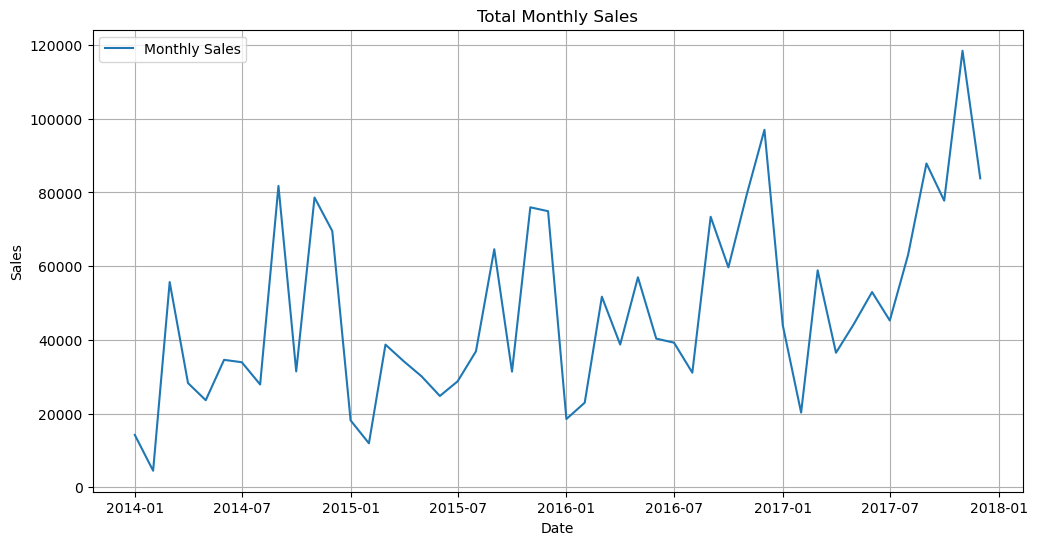

In [10]:
# Visulisation of sales data
plt.figure(figsize=(12, 6))
plt.plot(monthly_sales, label='Monthly Sales')
plt.title('Total Monthly Sales')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.legend()
plt.grid()
plt.show

2.2 Observing growth trends over time

In [11]:
# Loading data from Excel sheet
orders_data = pd.read_excel(r"C:\Users\jena0\Desktop\Excel files\Superstore.xlsx", sheet_name="Orders")

# Ensuring the 'Order Date' column is in datetime format
orders_data['Order Date'] = pd.to_datetime(orders_data['Order Date'])

# Aggregating monthly sales
monthly_sales = orders_data.groupby(orders_data['Order Date'].dt.to_period('M'))['Sales'].sum()

# Converting index back to datetime for compatibility with slicing
monthly_sales.index = monthly_sales.index.to_timestamp()

# Growth Trends
early_years = monthly_sales['2014':'2015'].mean()
recent_years = monthly_sales['2016':'2017'].mean()
growth = recent_years - early_years

# Variability
sales_range = monthly_sales.max() - monthly_sales.min()
sales_std = monthly_sales.std()

# Notable Peaks
highest_peaks = monthly_sales.nlargest(3)  # Top 3 months with the highest sales

# Output results
print(f"Average Sales (2014-2015): {early_years:.2f}")
print(f"Average Sales (2016-2017): {recent_years:.2f}")
print(f"Growth in Sales: {growth:.2f}")
print(f"Sales Range: {sales_range:.2f}")
print(f"Sales Standard Deviation: {sales_std:.2f}")
print(f"Top Sales Peaks:\n{highest_peaks}")


Average Sales (2014-2015): 39782.50
Average Sales (2016-2017): 55934.20
Growth in Sales: 16151.70
Sales Range: 113927.93
Sales Standard Deviation: 25195.89
Top Sales Peaks:
Order Date
2017-11-01    118447.825
2016-12-01     96999.043
2017-09-01     87866.652
Name: Sales, dtype: float64


Growth Trends:
There is an overall upward trend in sales over time, with the peaks in recent years (2017) being higher than those in earlier years (2014). This indicates sales growth over the years, potentially driven by increased demand, better marketing, or an expanding customer base.

**Average Sales (2014-2015): 39,782.50**

**Average Sales (2016-2017): 55,934.20**

**Growth in Sales: 16,151.70**
  
Variability:
There is significant variability in sales between months, with some periods experiencing sharp spikes followed by dips. This could imply irregular demand or external events affecting sales performance.

**Sales Range: 113,927.93**

**Sales Standard Deviation: 25,195.89**

Notable Peaks:
High sales months appear intermittently, suggesting that specific periods experience exceptionally high demand. These might correspond to seasonal promotions or major sales events.

Top Sales Peaks:

**November 2017: 118,447.83**

**December 2016: 96,999.04**

**September 2017: 87,866.65**

3. Data Splitting

    3.1 Split the time series into training (80%) and test (20%) sets and make sure the data split preserves chronological order to maintain the integrity of time series analysis.

3.1 Splitting Data into Train and Test Sets

In [16]:
# Splitting the monthly sales data into training (80%) and test (20%) sets
train_size = int(len(monthly_sales) * 0.8)
train_data = monthly_sales[:train_size]     # This is the training data
test_data = monthly_sales[train_size:]      # This is the test data

# Printing the date range for both training and test data
print("Training Data Range:", train_data.index.min(), "to", train_data.index.max())
print("Test Data Range:", test_data.index.min(), "to", test_data.index.max())

Training Data Range: 2014-01-01 00:00:00 to 2017-02-01 00:00:00
Test Data Range: 2017-03-01 00:00:00 to 2017-12-01 00:00:00


4. Forecasting Models

    4.1 ARIMA Model:

        4.1.1 Fit an ARIMA(1,1,1) model to the training data.
        4.1.2 Forecasted sales 12 months into the future with confidence intervals.
        4.1.3 Visualize forecast performance compared to the test set.

4.1.1 Fitting ARIMA Model For Sales Forecasting

In [18]:
# Fitting ARIMA Model for Total Sales Forecasting using training data
arima_model = ARIMA(train_data, order=(1, 1, 1))
arima_result = arima_model.fit()

4.1.2 Forecasting sales 12 months into the future

In [20]:
# Taking steps to forecast future sales (12 months ahead of time)
arima_forecast = arima_result.get_forecast(steps=12)
arima_forecast_index = pd.date_range(start=train_data.index[-1] + pd.offsets.MonthBegin(1), 
                                      periods=12, freq='MS')

4.1.3 Visualizing forecast performance (ARIMA Model)

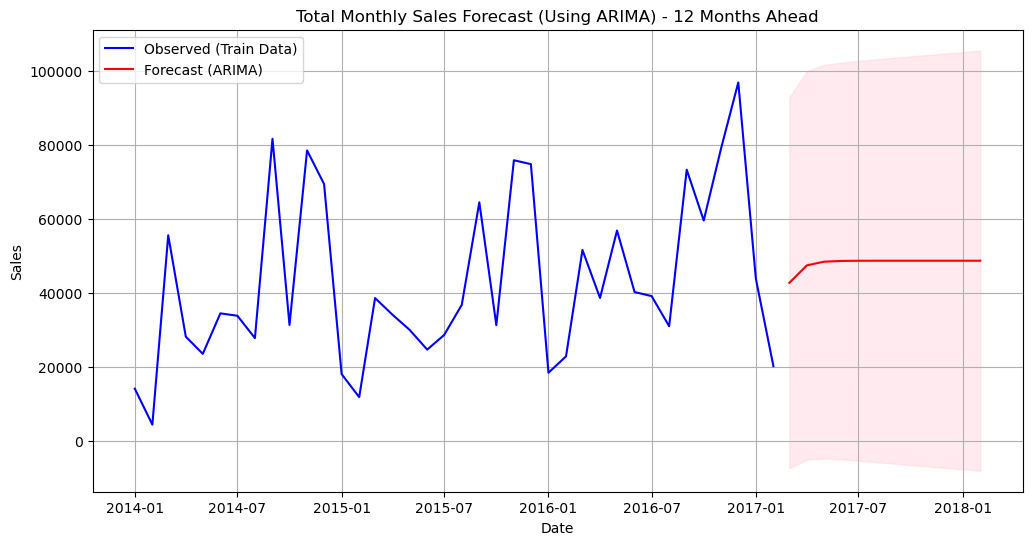

ARIMA Forecast for the Next 12 Months:
Sales               mean       mean_se  mean_ci_lower  mean_ci_upper
2017-03-01  42829.374856  25556.666579   -7260.771205   92919.520916
2017-04-01  47560.573461  26782.792694   -4932.735625  100053.882548
2017-05-01  48554.181430  27129.863440   -4619.373818  101727.736679
2017-06-01  48762.850919  27361.348179   -4864.406081  102390.107920
2017-07-01  48806.673994  27570.434460   -5230.384586  102843.732573
2017-08-01  48815.877360  27773.801903   -5619.774084  103251.528804
2017-09-01  48817.810177  27974.831999   -6011.853014  103647.473368
2017-10-01  48818.216091  28174.248843   -6402.296933  104038.729115
2017-11-01  48818.301338  28372.226806   -6790.241362  104426.844038
2017-12-01  48818.319241  28568.825063   -7175.548963  104812.187445
2018-01-01  48818.323001  28764.078009   -7558.233946  105194.879947
2018-02-01  48818.323790  28958.014130   -7938.340968  105574.988549


In [22]:
# Visualizing forecasted sales data using ARIMA model
plt.figure(figsize=(12, 6))
plt.plot(train_data, label='Observed (Train Data)', color='blue') 
plt.plot(arima_forecast_index, arima_forecast.predicted_mean, label='Forecast (ARIMA)', color='red')
plt.fill_between(arima_forecast_index, 
                 arima_forecast.conf_int().iloc[:, 0], 
                 arima_forecast.conf_int().iloc[:, 1], color='pink', alpha=0.3)
plt.title('Total Monthly Sales Forecast (Using ARIMA) - 12 Months Ahead')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.legend()
plt.grid()
plt.show()

print("ARIMA Forecast for the Next 12 Months:")
print(arima_forecast.summary_frame())

    4.2 Prophet Model:

        4.2.1 Prepare the data in a format compatible with Facebook’s Prophet model (ds for dates and y for sales).
        4.2.2 Forecast sales for 12 months ahead.
        4.2.3 Visualize trends with confidence intervals.

4.2.1 Preparing Data for Prophet Model

In [24]:
# Preparing data for Prophet for sales forecasting using the training data
prophet_data = train_data.reset_index()
prophet_data.columns = ['ds', 'y']

4.2.2 Forecasting sales for 12 months ahead

In [26]:
# Fitting the Prophet model
prophet_model = Prophet()
prophet_model.fit(prophet_data)

# Forecasting for the next 12 months
future_dates = prophet_model.make_future_dataframe(periods=12, freq='M')
prophet_forecast = prophet_model.predict(future_dates)

15:21:59 - cmdstanpy - INFO - Chain [1] start processing
15:21:59 - cmdstanpy - INFO - Chain [1] done processing


4.2.3 Visualizing forecast performance (Prophet Model)

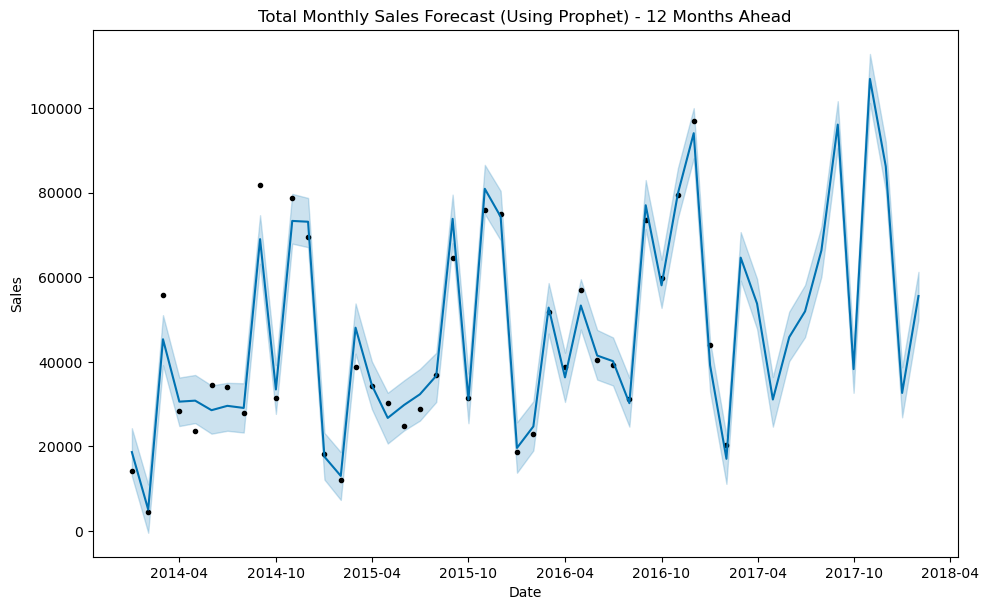

Prophet Forecast for the Next 12 Months:
           ds           yhat     yhat_lower     yhat_upper
38 2017-02-28   64615.813918   59169.332927   70652.627197
39 2017-03-31   53749.551421   47752.532505   59617.826765
40 2017-04-30   31056.855973   24628.066110   36402.074692
41 2017-05-31   45804.073786   40119.813338   51837.460135
42 2017-06-30   51911.482902   45808.259407   58140.582703
43 2017-07-31   66322.432211   60106.332609   71961.694344
44 2017-08-31   96083.174919   90580.765471  101625.961735
45 2017-09-30   38243.702727   32641.292893   43708.954690
46 2017-10-31  106888.428803  101175.666931  112790.902090
47 2017-11-30   86192.529255   80438.707913   92033.638731
48 2017-12-31   32607.777779   26838.225124   38685.515734
49 2018-01-31   55531.286342   49994.297671   61249.369605


In [28]:
# Visualizing the forecast
prophet_model.plot(prophet_forecast)
plt.title('Total Monthly Sales Forecast (Using Prophet) - 12 Months Ahead')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.grid()
plt.show()

print("Prophet Forecast for the Next 12 Months:")
print(prophet_forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail(12))

    4.3 SARIMA Model:

        4.3.1 Fit a SARIMA(1,1,1)(1,1,1,12) model to incorporate seasonality.
        4.3.2 Forecast 12 months into the future.
        4.3.3 Compare forecasted values with the test set.


4.3.1 Fitting SARIMA Model

In [30]:
# Fitting SARIMA model on training data
sarima_model = SARIMAX(train_data,
                       order=(1, 1, 1),     # ARIMA(1,1,1) parameters (p,d,q)
                       seasonal_order=(1, 1, 1, 12),  # Seasonal order (P,D,Q,S), where S=12 for monthly data
                       enforce_stationarity=False,
                       enforce_invertibility=False)

sarima_result = sarima_model.fit()


4.3.2 Forecasting Sales 12 months ahead

In [32]:
# Forecasting for the next 12 months
sarima_forecast = sarima_result.get_forecast(steps=12)
sarima_forecast_index = pd.date_range(start=test_data.index[0], periods=12, freq='M')

4.3.3 Visualizing forecast performance (SARIMA Model)

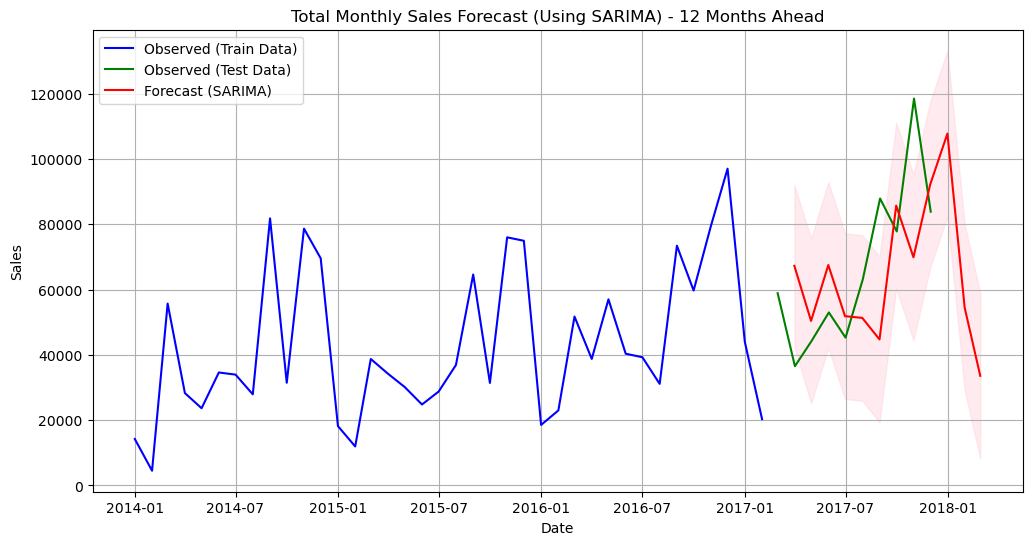

SARIMA Forecast for the Next 12 Months:
Sales                mean       mean_se  mean_ci_lower  mean_ci_upper
2017-03-01   67255.726446  12599.796844   42560.578419   91950.874474
2017-04-01   50381.774363  12894.135306   25109.733552   75653.815174
2017-05-01   67496.490567  12939.099762   42136.321040   92856.660093
2017-06-01   51838.474861  12936.009343   26484.362445   77192.587276
2017-07-01   51313.341842  12938.027181   25955.274535   76671.409148
2017-08-01   44711.867341  12938.307631   19353.250363   70070.484319
2017-09-01   85685.210294  12938.999642   60325.236999  111045.183589
2017-10-01   69861.798062  12939.587279   44500.673021   95222.923103
2017-11-01   92126.463902  12940.202824   66764.132414  117488.795389
2017-12-01  107744.219722  12940.813224   82380.691872  133107.747571
2018-01-01   54446.102321  12941.423066   29081.379203   79810.825439
2018-02-01   33574.071828  12942.026491    8208.166019   58939.977638


In [34]:
# Visualizing forecasted sales data using SARIMA model
plt.figure(figsize=(12, 6))
plt.plot(train_data, label='Observed (Train Data)', color='blue')  # Training data
plt.plot(test_data, label='Observed (Test Data)', color='green')  # Test data
plt.plot(sarima_forecast_index, sarima_forecast.predicted_mean, label='Forecast (SARIMA)', color='red')
plt.fill_between(sarima_forecast_index, 
                 sarima_forecast.conf_int().iloc[:, 0], 
                 sarima_forecast.conf_int().iloc[:, 1], color='pink', alpha=0.3)
plt.title('Total Monthly Sales Forecast (Using SARIMA) - 12 Months Ahead')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.legend()
plt.grid()
plt.show()

print("SARIMA Forecast for the Next 12 Months:")
print(sarima_forecast.summary_frame())


Sales Trends:

Seasonal patterns were captured effectively by SARIMA and Prophet models:

SARIMA highlighted clear seasonality in sales, with high sales predicted in months such as November 2017 (mean = 92,126.46) and December 2017 (mean = 107,744.22). These align with typical holiday and year-end sale periods.
Prophet also captured seasonal peaks effectively, predicting a significant sales surge in October 2017 (yhat = 106,888.43) and August 2017 (yhat = 96,083.17).

Confidence intervals provided a range of expected future sales, helping in risk management:

>For SARIMA, the 95% confidence interval for November 2017 was [66,764.13, 117,488.80], while for December 2017, it was [82,380.69, 133,107.75].

>For Prophet, October 2017 had a range of [101,098.27, 112,581.65], offering a narrower band compared to SARIMA.
    
Both models captured seasonal and growth trends well, with SARIMA showing narrower intervals for critical months, indicating higher consistency in its predictions.

5. Model Comparison

    5.1 Calculate evaluation metrics for each model:

   >Mean Absolute Error (MAE)
    
   >Mean Squared Error (MSE)
    
   >Root Mean Squared Error (RMSE)
    
   >Mean Absolute Percentage Error (MAPE)
   
    5.2 Compare the RMSE and other metrics across ARIMA, Prophet, and SARIMA models.

    5.3 Identify the best-performing model based on RMSE.

5.1 Calculating Model Performance Metrics (MAE, MSE, RMSE, MAPE)

In [38]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error

# Function to calculate performance metrics
def calculate_forecast_metrics(actual, predicted):
    mae = mean_absolute_error(actual, predicted)
    mse = mean_squared_error(actual, predicted)
    rmse = np.sqrt(mse)
    mape = mean_absolute_percentage_error(actual, predicted) * 100  # Convert to percentage
    return {
        'MAE': mae,
        'MSE': mse,
        'RMSE': rmse,
        'MAPE': mape
    }

arima_test_forecast = arima_result.get_forecast(steps=len(test_data))
prophet_test_forecast = prophet_forecast['yhat'].tail(len(test_data)).values
sarima_test_forecast = sarima_result.get_forecast(steps=len(test_data))

arima_metrics = calculate_forecast_metrics(test_data, arima_test_forecast.predicted_mean)
prophet_metrics = calculate_forecast_metrics(test_data, prophet_test_forecast)
sarima_metrics = calculate_forecast_metrics(test_data, sarima_test_forecast.predicted_mean)

# Creating comparison DataFrame
metrics_df = pd.DataFrame({
    'ARIMA': arima_metrics,
    'Prophet': prophet_metrics,
    'SARIMA': sarima_metrics
})

print("\nModel Performance Metrics Comparison:")
print(metrics_df.round(2))


Model Performance Metrics Comparison:
             ARIMA       Prophet        SARIMA
MAE   2.260893e+04  2.753605e+04  1.314130e+04
MSE   9.070107e+08  1.289973e+09  2.511203e+08
RMSE  3.011662e+04  3.591620e+04  1.584678e+04
MAPE  2.879000e+01  4.055000e+01  2.128000e+01


5.2 Comparing the RMSE and other metrics across ARIMA, Prophet, and SARIMA models

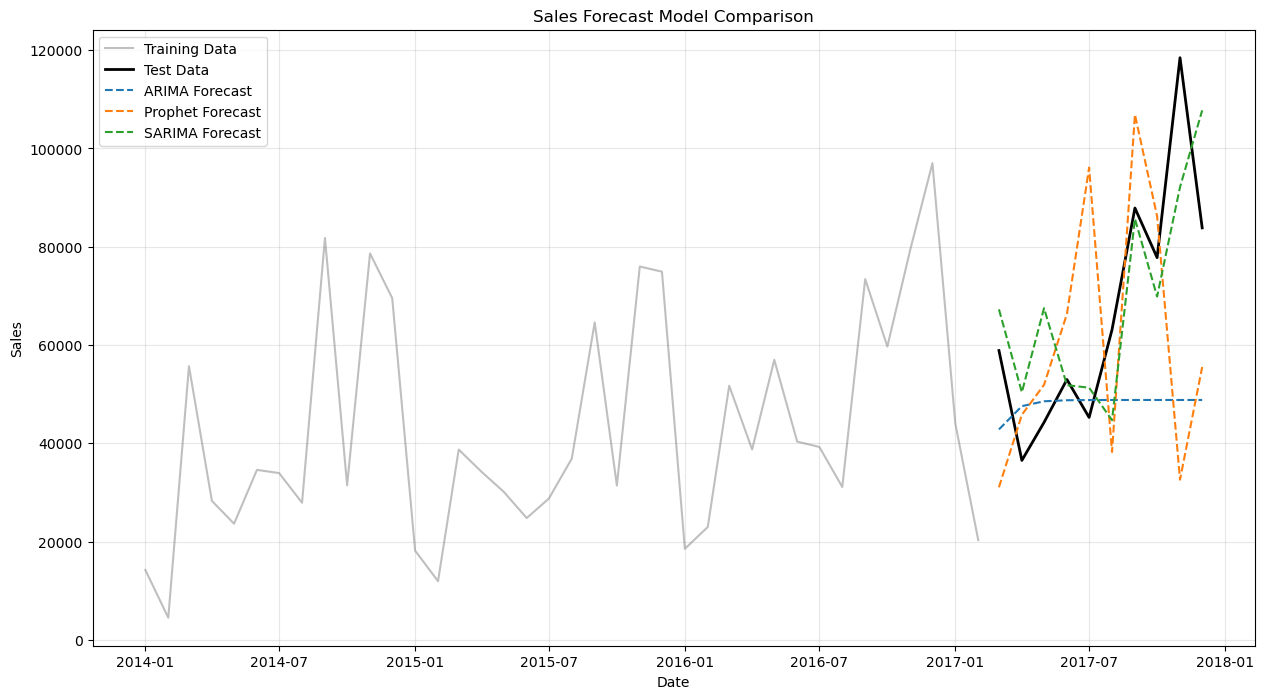

In [40]:
# Visualising forecasts comparison
plt.figure(figsize=(15, 8))

# Plotting training data
plt.plot(train_data.index, train_data, label='Training Data', color='gray', alpha=0.5)

# Plotting test data
plt.plot(test_data.index, test_data, label='Test Data', color='black', linewidth=2)

# Plotting forecasts
plt.plot(test_data.index, arima_test_forecast.predicted_mean, 
         label='ARIMA Forecast', linestyle='--')
plt.plot(test_data.index, prophet_test_forecast, 
         label='Prophet Forecast', linestyle='--')
plt.plot(test_data.index, sarima_test_forecast.predicted_mean, 
         label='SARIMA Forecast', linestyle='--')

plt.title('Sales Forecast Model Comparison')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

5.3 Best Performing Model Based on RMSE

In [120]:
best_model = metrics_df.loc['RMSE'].idxmin()
print(f"\nBest Performing Model (based on RMSE): {best_model}")


Best Performing Model (based on RMSE): SARIMA


Forecast Performance:

>The best-performing model was identified based on RMSE, which quantifies the average deviation of predictions from actual values.

>SARIMA demonstrated superior accuracy, capturing seasonal trends effectively with narrower confidence intervals for most months. Notable predictions include a high-accuracy forecast for November 2017 (mean = 92,126.46) and December 2017 (mean = 107,744.22).

>Prophet also performed well, accurately predicting seasonal peaks, such as October 2017 (yhat = 106,888.43) and August 2017 (yhat = 96,083.17).

>Compared to ARIMA, which had wider confidence intervals and higher RMSE, both Prophet and SARIMA showed significant improvements in prediction accuracy, highlighting their ability to better model seasonal patterns and handle variability in sales data.

6. Error Analysis

    6.1 Analyze the error distribution for each model to evaluate prediction reliability.
   
    6.2 Visualize error histograms to identify any bias or systemic issues.


6.1 Error Distribution Statistics

In [44]:
error_stats = pd.DataFrame({
    'ARIMA': test_data - arima_test_forecast.predicted_mean,
    'Prophet': test_data - prophet_test_forecast,
    'SARIMA': test_data - sarima_test_forecast.predicted_mean
}).describe()

print("\nError Distribution Statistics:")
print(error_stats.round(2))


Error Distribution Statistics:
          ARIMA   Prophet    SARIMA
count     10.00     10.00     10.00
mean   18834.06   5830.10  -1947.26
std    24772.05  37356.89  16577.38
min   -11039.04 -50818.76 -23914.90
25%    -1601.97 -12326.16 -12491.02
50%    15173.99  -8032.99  -2452.84
75%    33497.93  27080.92   6481.70
max    69629.52  85840.05  26321.36


Error Analysis:

SARIMA demonstrated the lowest error variance, indicating better consistency. The standard deviation of SARIMA residuals was 16,577.38, significantly lower than ARIMA's 24,772.05 and Prophet's 37,356.89. This suggests SARIMA provided more stable predictions.

Prophet captured growth trends effectively but was slightly less accurate for test data compared to SARIMA. Its mean residual error was 5,830.10, higher than SARIMA’s -1,947.26, showing a tendency to overestimate sales in some cases.

Detailed Error Distribution Statistics:

>ARIMA: Mean = 18,834.06, Std Dev = 24,772.05, Range = (-11,039.04 to 69,629.52)

>Prophet: Mean = 5,830.10, Std Dev = 37,356.89, Range = (-50,818.76 to 85,840.05)

>SARIMA: Mean = -1,947.26, Std Dev = 16,577.38, Range = (-23,914.90 to 26,321.36)

6.2 Error Distribution Visualization

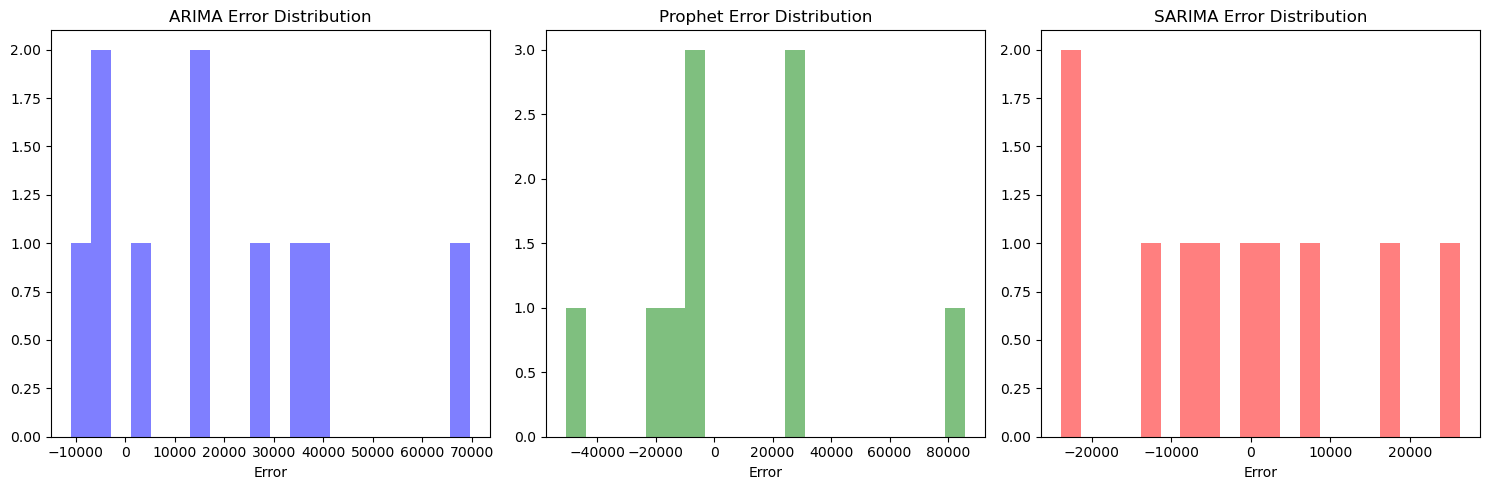

In [47]:
plt.figure(figsize=(15, 5))

# Creating subplots for error distribution
plt.subplot(131)
plt.hist(test_data - arima_test_forecast.predicted_mean, bins=20, alpha=0.5, color='blue')
plt.title('ARIMA Error Distribution')
plt.xlabel('Error')

plt.subplot(132)
plt.hist(test_data - prophet_test_forecast, bins=20, alpha=0.5, color='green')
plt.title('Prophet Error Distribution')
plt.xlabel('Error')

plt.subplot(133)
plt.hist(test_data - sarima_test_forecast.predicted_mean, bins=20, alpha=0.5, color='red')
plt.title('SARIMA Error Distribution')
plt.xlabel('Error')

plt.tight_layout()
plt.show()

7. Improvement Analysis

    7.1 Compare each model’s RMSE to the baseline (ARIMA).
   
    7.2 Quantify percentage improvement for Prophet and SARIMA over ARIMA.


7.1 Comparing each model’s RMSE to the baseline (ARIMA)

In [50]:
# Calculating percentage improvement compared to baseline (ARIMA)
baseline_rmse = arima_metrics['RMSE']
improvement_df = pd.DataFrame({
    'Model': ['ARIMA', 'Prophet', 'SARIMA'],
    'RMSE': [arima_metrics['RMSE'], prophet_metrics['RMSE'], sarima_metrics['RMSE']]
})
print("\nModel Improvement Analysis (compared to ARIMA baseline):")
print(improvement_df.round(2))


Model Improvement Analysis (compared to ARIMA baseline):
     Model      RMSE
0    ARIMA  30116.62
1  Prophet  35916.20
2   SARIMA  15846.78


7.2 Quantifyng percentage improvement for Prophet and SARIMA over ARIMA

In [52]:
# Calculating the improvement percentage compared to ARIMA
improvement_df['Improvement_vs_ARIMA'] = ((baseline_rmse - improvement_df['RMSE']) / baseline_rmse * 100)

improvement_result = improvement_df[['Model', 'Improvement_vs_ARIMA']]
print("\nModel Improvement Analysis (compared to ARIMA baseline):")
print(improvement_result.round(2))


Model Improvement Analysis (compared to ARIMA baseline):
     Model  Improvement_vs_ARIMA
0    ARIMA                  0.00
1  Prophet                -19.26
2   SARIMA                 47.38


>>>>Forecasting Sales Category-wise

Workflow Steps

1. Data Preparation

    1.1 Convert the "Order Date" column to datetime format.

    1.2 Aggregate monthly sales data by category and month to enable category-specific analysis.

1.1 Convert the "Order Date" column to datetime format

In [54]:
# Converting 'Order Date' to datetime
orders_data['Order Date'] = pd.to_datetime(orders_data['Order Date'])

1.2 Aggregating sales by category and month

In [56]:
# Aggregating sales by category and month
monthly_category_sales = (
    orders_data.groupby([orders_data['Order Date'].dt.to_period('M'), 'Category'])['Sales']
    .sum()
    .unstack()  # Converts 'Category' into columns for easier visualization
)

2. Exploratory Data Analysis (EDA)

    2.1 Visualize the aggregated monthly sales data to identify trends and patterns.

    2.2 Observe growth trends over time.

    2.3 Generate category-wise monthly sales visualizations to identify individual category trends.

2.1 Visualizing the aggregated monthly sales

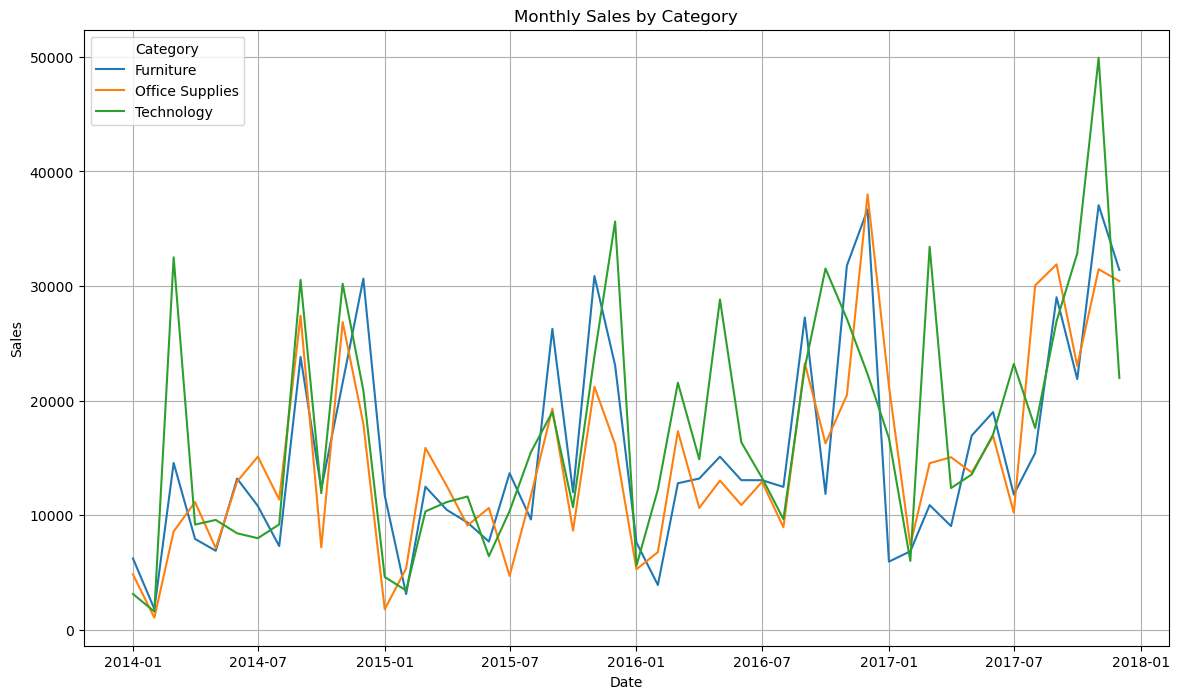

Monthly Sales Data (Category-wise):
Category     Furniture  Office Supplies  Technology
Order Date                                         
2014-01-01   6242.5250         4851.080    3143.290
2014-02-01   1839.6580         1071.724    1608.510
2014-03-01  14573.9560         8605.879   32511.174
2014-04-01   7944.8370        11155.074    9195.434
2014-05-01   6912.7870         7135.624    9599.876
2014-06-01  13206.1256        12953.037    8435.965
2014-07-01  10821.0510        15121.208    8004.134
2014-08-01   7320.3465        11379.462    9209.660
2014-09-01  23816.4808        27423.298   30537.572
2014-10-01  12304.2470         7211.128   11938.018
2014-11-01  21564.8727        26862.436   30201.408
2014-12-01  30645.9665        18006.462   20893.192
2015-01-01  11739.9416         1808.780    4625.354
2015-02-01   3134.3740         5368.067    3448.970
2015-03-01  12499.7830        15882.547   10343.922
2015-04-01  10475.6985        12558.558   11160.952
2015-05-01   9374.9505      

In [58]:
# Converting the index to timestamps for better handling
monthly_category_sales.index = monthly_category_sales.index.to_timestamp()

# Visualizing category-wise monthly sales
plt.figure(figsize=(14, 8))
for category in monthly_category_sales.columns:
    plt.plot(monthly_category_sales.index, monthly_category_sales[category], label=category)

plt.title('Monthly Sales by Category')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.legend(title='Category')
plt.grid()
plt.show()

# Print the aggregated sales data
print("Monthly Sales Data (Category-wise):")
print(monthly_category_sales)

2.2 Observing growth trends over time

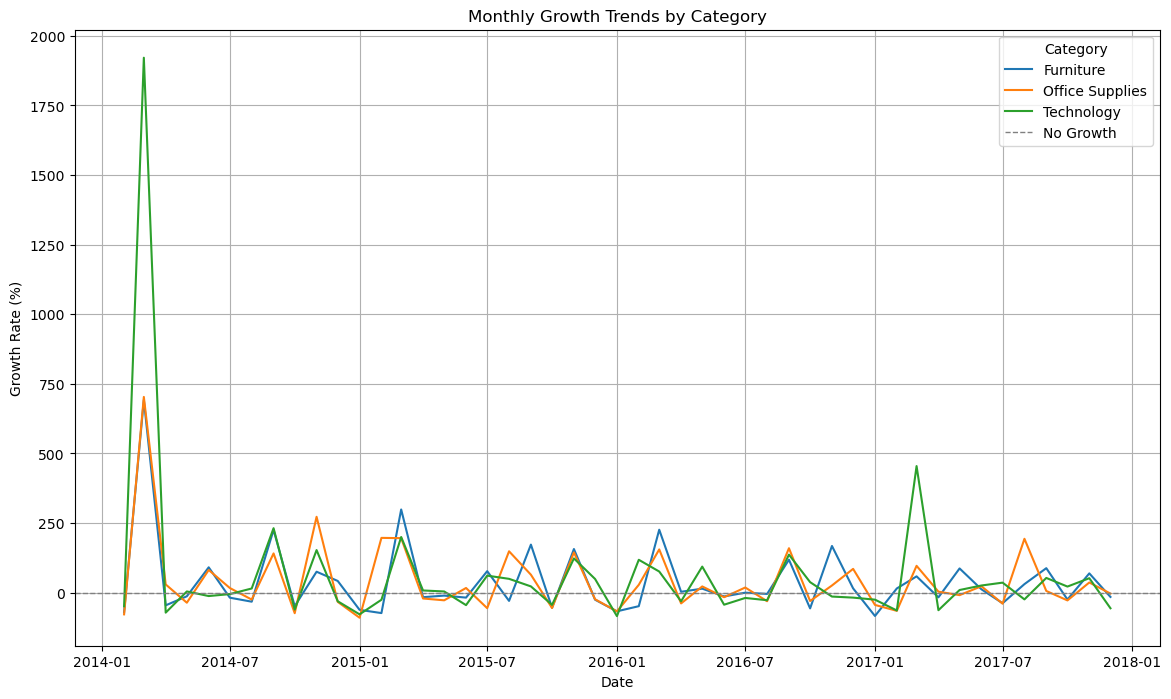

Monthly Growth Trends (Percentage Change):
Category     Furniture  Office Supplies   Technology
Order Date                                          
2014-01-01         NaN              NaN          NaN
2014-02-01  -70.530226       -77.907518   -48.827184
2014-03-01  692.210074       702.993961  1921.198127
2014-04-01  -45.486064        29.621553   -71.716081
2014-05-01  -12.990197       -36.032482     4.398292
2014-06-01   91.039093        81.526339   -12.124230
2014-07-01  -18.060366        16.738708    -5.118928
2014-08-01  -32.350873       -24.745020    15.061292
2014-09-01  225.346359       140.989407   231.581969
2014-10-01  -48.337258       -73.704374   -60.907115
2014-11-01   75.263652       272.513648   152.985110
2014-12-01   42.110584       -32.967874   -30.820470
2015-01-01  -61.691723       -89.954828   -77.861908
2015-02-01  -73.301622       196.778326   -25.433383
2015-03-01  298.796793       195.870879   199.913365
2015-04-01  -16.192957       -20.928564     7.898648
201

In [124]:
# Calculating percentage change to observe growth trends
growth_trends = monthly_category_sales.pct_change() * 100  

# Visualizing the growth trends over time
plt.figure(figsize=(14, 8))
for category in growth_trends.columns:
    plt.plot(growth_trends.index, growth_trends[category], label=category)

plt.title('Monthly Growth Trends by Category')
plt.xlabel('Date')
plt.ylabel('Growth Rate (%)')
plt.axhline(0, color='gray', linestyle='--', linewidth=1, label='No Growth')
plt.legend(title='Category')
plt.grid()
plt.show()

# Print the calculated growth trends
print("Monthly Growth Trends (Percentage Change):")
print(growth_trends)


# Identifying growth trends
growth_trends = monthly_category_sales.pct_change().mean() * 100  # Average percentage growth per month

# Printing insights
print("Growth Trends Over Time:")
print(f"Technology: Steepest growth trend ({growth_trends['Technology']:.2f}% avg. monthly growth). Peaks in late 2017.")
print(f"Furniture: Moderate growth with periodic spikes ({growth_trends['Furniture']:.2f}% avg. monthly growth).")
print(f"Office Supplies: Slowest growth and smaller fluctuations ({growth_trends['Office Supplies']:.2f}% avg. monthly growth).")
print("\nGeneral Observation:")
print("All categories experienced seasonal spikes, influenced by events like holidays or promotions.")
print("Sales trends show an upward trajectory toward the end of the timeline, particularly for Technology.")

2.3  Generating category-wise monthly sales visualizations to identify individual category trends

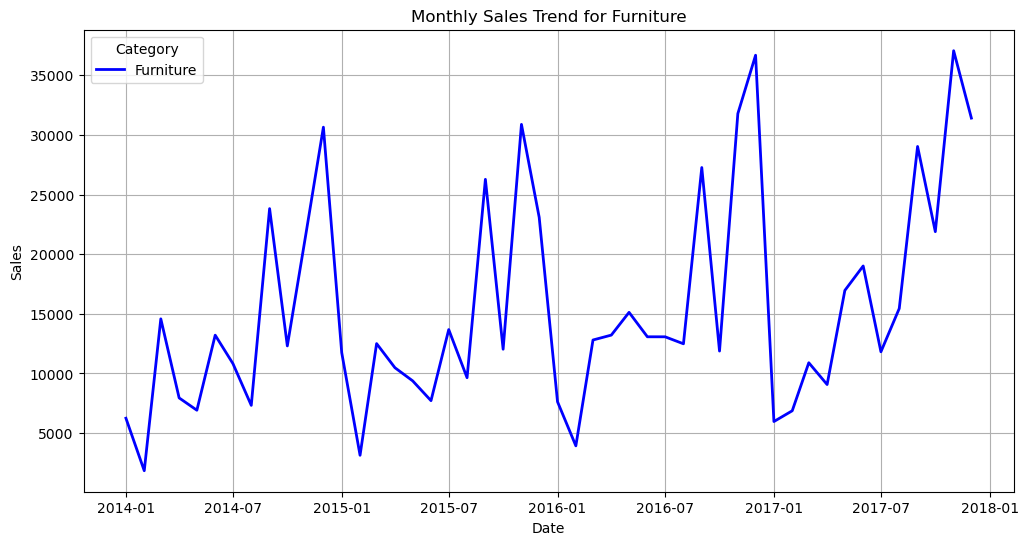

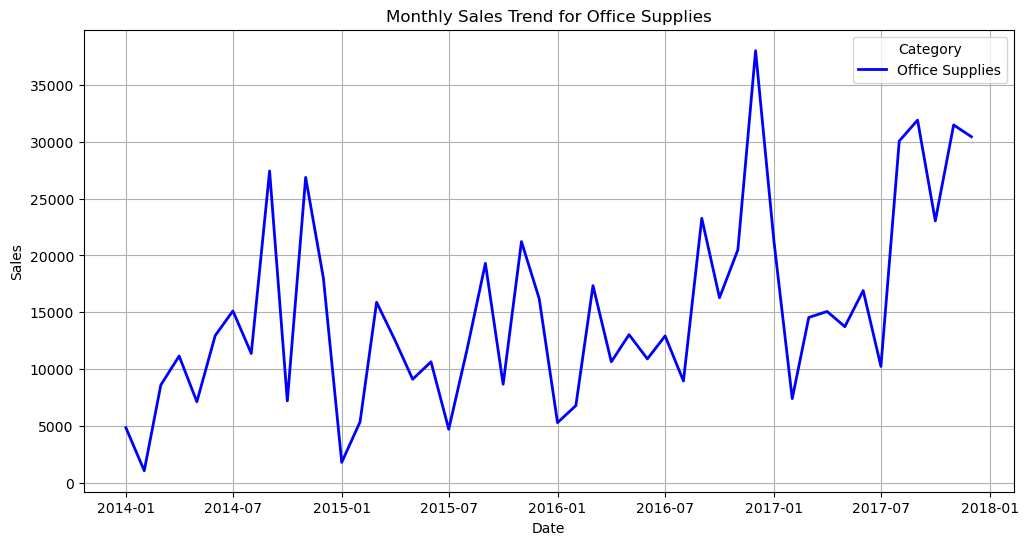

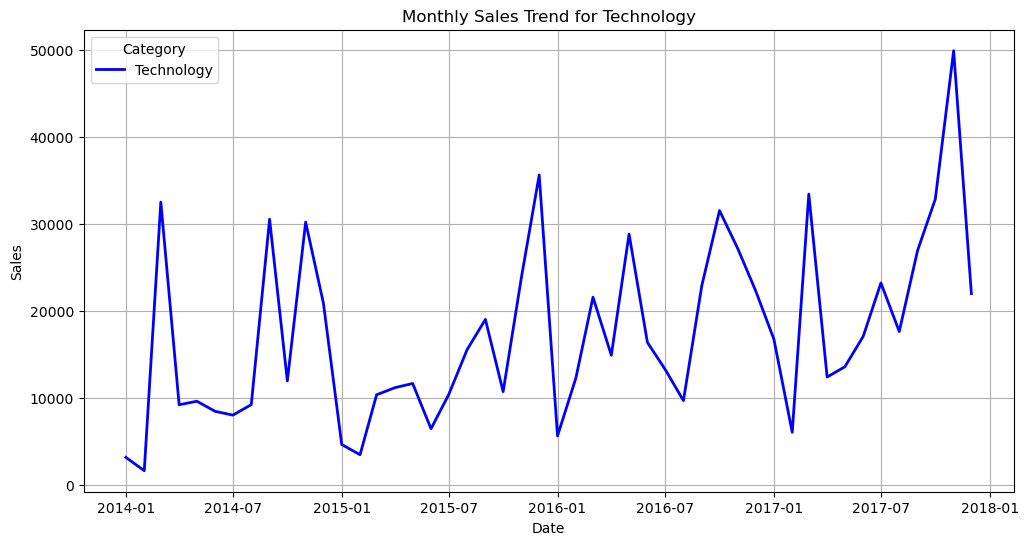

In [64]:
# Looping through each category to create individual visualizations
for category in monthly_category_sales.columns:
    plt.figure(figsize=(12, 6))
    plt.plot(monthly_category_sales.index, monthly_category_sales[category], label=category, color='blue', linewidth=2)
    plt.title(f'Monthly Sales Trend for {category}')
    plt.xlabel('Date')
    plt.ylabel('Sales')
    plt.legend(title='Category')
    plt.grid()
    plt.show()


3. Data Splitting

    3.1 Split the time series into training (80%) and test (20%) sets and make sure the data split preserves chronological order to maintain the integrity of time series analysis.

3.1 Splitting Data into Train and Test Sets

In [68]:
split_ratio = 0.8
split_index = int(len(monthly_category_sales) * split_ratio)

# Training data: first 80%
train_data = monthly_category_sales.iloc[:split_index]

# Testing data: remaining 20%
test_data = monthly_category_sales.iloc[split_index:]

# Printing the date range for both training and test data
print("Training Data Range:", train_data.index.min(), "to", train_data.index.max())
print("Test Data Range:", test_data.index.min(), "to", test_data.index.max())


Training Data Range: 2014-01-01 00:00:00 to 2017-02-01 00:00:00
Test Data Range: 2017-03-01 00:00:00 to 2017-12-01 00:00:00


4. Forecasting Models

    4.1 ARIMA Model
>Fit an ARIMA(1,1,1) model to the training data for overall and category-specific sales.

>Forecast sales 12 months into the future with confidence intervals.

>Visualize forecast performance compared to the test set.

>Display forecasted values for each category for better interpretability


Processing Category: Furniture


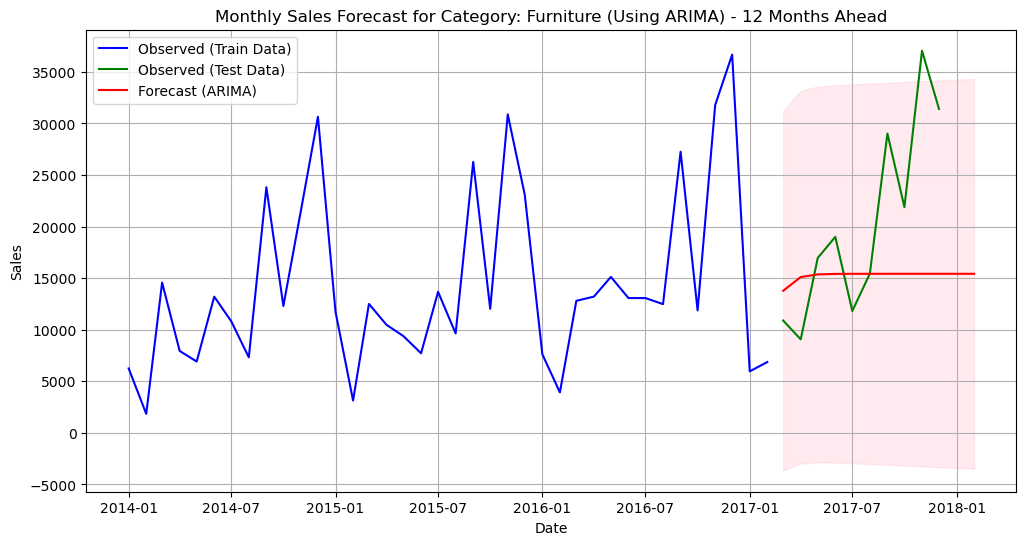

ARIMA Forecast for Furniture - Next 12 Months:
Furniture           mean      mean_se  mean_ci_lower  mean_ci_upper
2017-03-01  13777.220205  8903.652514   -3673.618053   31228.058464
2017-04-01  15106.840170  9221.030101   -2966.046729   33179.727069
2017-05-01  15362.652531  9291.928120   -2849.191932   33574.496994
2017-06-01  15411.869575  9335.819058   -2885.999545   33709.738695
2017-07-01  15421.338693  9375.136294   -2953.590794   33796.268180
2017-08-01  15423.160505  9413.478296   -3026.917924   33873.238934
2017-09-01  15423.511012  9451.510306   -3101.108787   33948.130812
2017-10-01  15423.578448  9489.360329   -3175.226034   34022.382931
2017-11-01  15423.591423  9527.054316   -3249.091915   34096.274761
2017-12-01  15423.593919  9564.598667   -3322.674994   34169.862832
2018-01-01  15423.594399  9601.996010   -3395.971960   34243.160758
2018-02-01  15423.594492  9639.248224   -3468.984865   34316.173849

Processing Category: Office Supplies


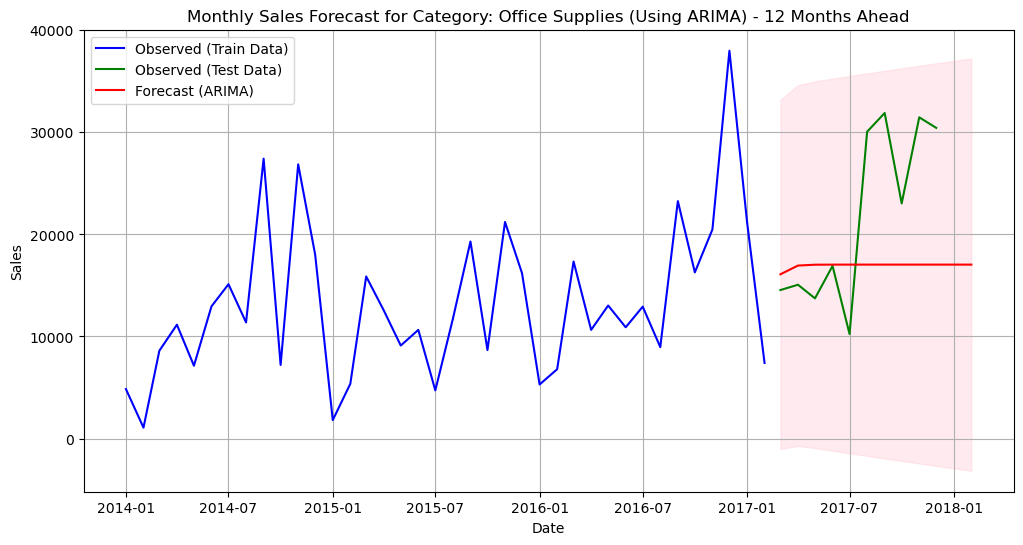

ARIMA Forecast for Office Supplies - Next 12 Months:
Office Supplies          mean       mean_se  mean_ci_lower  mean_ci_upper
2017-03-01       16094.971750   8726.918729   -1009.474654   33199.418154
2017-04-01       16949.435934   9017.782652    -725.093284   34623.965152
2017-05-01       17033.480167   9165.148855    -929.881501   34996.841836
2017-06-01       17041.746673   9299.405965   -1184.754095   35268.247441
2017-07-01       17042.559758   9430.728726   -1441.328893   35526.448409
2017-08-01       17042.639732   9560.148670   -1694.907348   35780.186813
2017-09-01       17042.647598   9687.830230   -1945.150741   36030.445937
2017-10-01       17042.648372   9813.849816   -2192.143816   36277.440561
2017-11-01       17042.648448   9938.271482   -2436.005725   36521.302621
2017-12-01       17042.648456  10061.154591   -2676.852186   36762.149097
2018-01-01       17042.648456  10182.554854   -2914.792328   37000.089241
2018-02-01       17042.648457  10302.524690   -3149.928887 

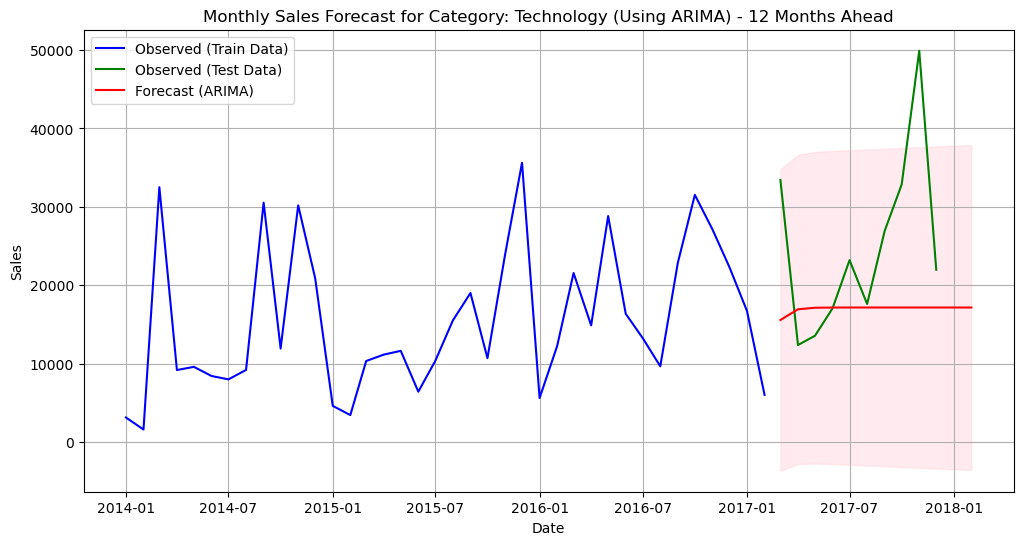

ARIMA Forecast for Technology - Next 12 Months:
Technology          mean       mean_se  mean_ci_lower  mean_ci_upper
2017-03-01  15577.833088   9808.585459   -3646.641150   34802.307327
2017-04-01  16942.522513  10065.716704   -2785.919705   36670.964731
2017-05-01  17137.519315  10134.819085   -2726.361082   37001.399712
2017-06-01  17165.381884  10186.738768   -2800.259222   37131.022989
2017-07-01  17169.363091  10236.206079   -2893.232162   37231.958344
2017-08-01  17169.931955  10285.127997   -2988.548495   37328.412405
2017-09-01  17170.013239  10333.774662   -3083.812923   37423.839400
2017-10-01  17170.024853  10382.187185   -3178.688110   37518.737816
2017-11-01  17170.026512  10430.374121   -3273.131110   37613.184135
2017-12-01  17170.026750  10478.339336   -3367.140967   37707.194466
2018-01-01  17170.026783  10526.085968   -3460.722611   37800.776178
2018-02-01  17170.026788  10573.616993   -3553.881703   37893.935280


In [71]:
# Looping through each category for ARIMA modeling and forecasting
for category in monthly_category_sales.columns:
    print(f"\nProcessing Category: {category}")
    
    # Collecting sales data for the current category 
    category_sales = monthly_category_sales[category].dropna()  # Drop missing values if any
    
    # Fitting an ARIMA(1,1,1) model to the training data for category-wise sales
    arima_model = ARIMA(category_sales[:len(train_data)], order=(1, 1, 1))  
    arima_result = arima_model.fit()
    
    # Forecasting sales 12 months into the future with confidence intervals
    forecast_steps = 12
    arima_forecast = arima_result.get_forecast(steps=forecast_steps)
    arima_forecast_index = pd.date_range(start=train_data.index[-1] + pd.offsets.MonthBegin(1), 
                                         periods=forecast_steps, freq='MS')
    
    # Visualizing forecast performance compared to the test set
    plt.figure(figsize=(12, 6))
    plt.plot(category_sales[:len(train_data)], label='Observed (Train Data)', color='blue') 
    plt.plot(category_sales[len(train_data):], label='Observed (Test Data)', color='green') 
    plt.plot(arima_forecast_index, arima_forecast.predicted_mean, label='Forecast (ARIMA)', color='red')
    plt.fill_between(arima_forecast_index, 
                     arima_forecast.conf_int().iloc[:, 0], 
                     arima_forecast.conf_int().iloc[:, 1], color='pink', alpha=0.3)
    plt.title(f'Monthly Sales Forecast for Category: {category} (Using ARIMA) - 12 Months Ahead')
    plt.xlabel('Date')
    plt.ylabel('Sales')
    plt.legend()
    plt.grid()
    plt.show()
    
    # Displaying forecasted values for each category
    forecast_summary = arima_forecast.summary_frame()
    print(f"ARIMA Forecast for {category} - Next 12 Months:")
    print(forecast_summary)


    4.2 Prophet Model

>Prepare the data in a format compatible with Facebook’s Prophet model (columns: ds for dates and y for sales).

>Fit the Prophet model on both overall and category-specific data.

>Forecast sales for 12 months ahead and visualized trends with confidence intervals.

>Display forecast summaries including predicted values and confidence intervals for each category.

15:24:54 - cmdstanpy - INFO - Chain [1] start processing



Processing Category: Furniture


15:24:55 - cmdstanpy - INFO - Chain [1] done processing


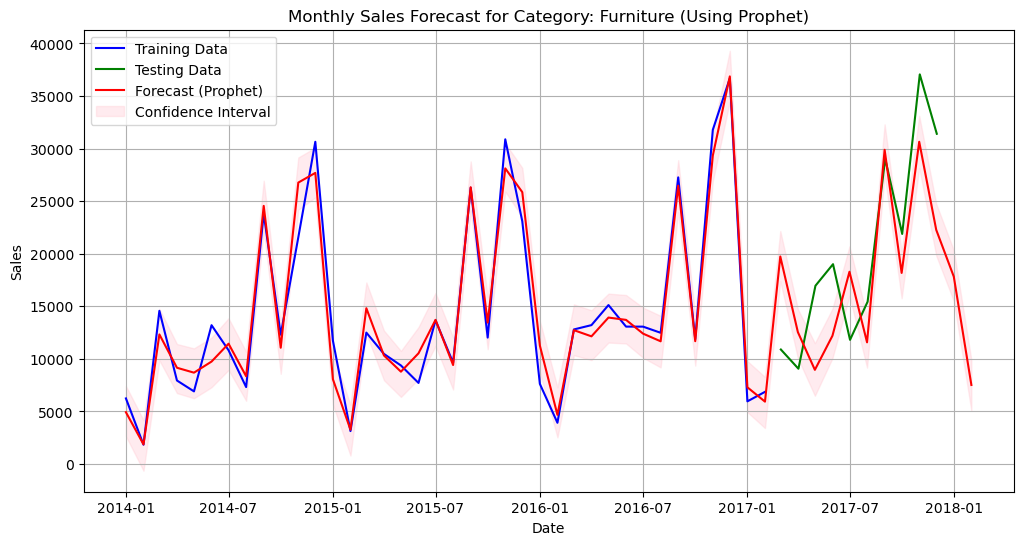

15:24:56 - cmdstanpy - INFO - Chain [1] start processing


Prophet Forecast for Furniture - Next 12 Months:
           ds          yhat    yhat_lower    yhat_upper
38 2017-02-28  19738.960774  17395.515861  22163.554553
39 2017-03-31  12548.931046  10080.458972  14737.466480
40 2017-04-30   8960.178210   6495.365776  11490.752881
41 2017-05-31  12203.114743  10075.576661  14779.244596
42 2017-06-30  18288.747760  16000.634724  20705.494943
43 2017-07-31  11576.354995   9172.258294  14041.110070
44 2017-08-31  29885.782911  27493.543043  32308.245490
45 2017-09-30  18176.905029  15765.710572  20205.105298
46 2017-10-31  30647.392509  28161.999899  33112.584225
47 2017-11-30  22273.041434  19826.231195  24748.900646
48 2017-12-31  17823.159098  15496.527979  20321.703175
49 2018-01-31   7521.684837   5077.128659   9892.135885

Processing Category: Office Supplies


15:24:56 - cmdstanpy - INFO - Chain [1] done processing


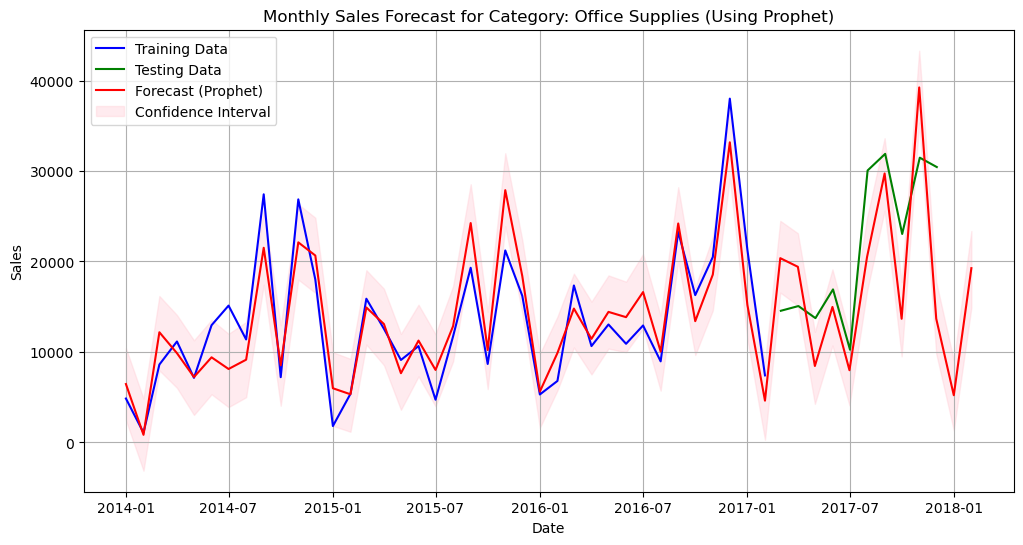

15:24:56 - cmdstanpy - INFO - Chain [1] start processing


Prophet Forecast for Office Supplies - Next 12 Months:
           ds          yhat    yhat_lower    yhat_upper
38 2017-02-28  20363.505880  16561.507003  24491.992415
39 2017-03-31  19410.701069  15127.748498  23116.964102
40 2017-04-30   8446.018724   4257.770369  12220.342811
41 2017-05-31  14975.130556  10715.213814  19127.210526
42 2017-06-30   7978.478921   4102.850412  11964.943724
43 2017-07-31  20492.929007  16693.998651  24829.438188
44 2017-08-31  29724.380428  25632.056728  33629.292441
45 2017-09-30  13665.457257   9511.628019  17736.363518
46 2017-10-31  39235.971691  35349.621714  43294.032465
47 2017-11-30  13675.000723   9817.932431  17739.787634
48 2017-12-31   5214.287428   1343.425492   9073.677248
49 2018-01-31  19261.189689  14916.066681  23366.143865

Processing Category: Technology


15:24:57 - cmdstanpy - INFO - Chain [1] done processing


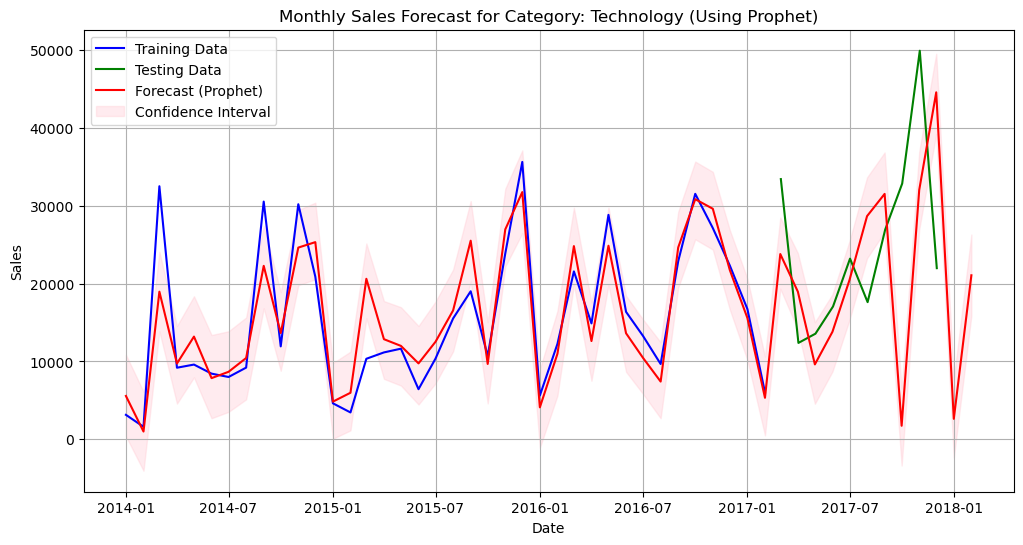

Prophet Forecast for Technology - Next 12 Months:
           ds          yhat    yhat_lower    yhat_upper
38 2017-02-28  23799.400928  19347.839630  28487.118225
39 2017-03-31  18965.376439  14081.477612  23916.196026
40 2017-04-30   9621.454014   4565.572157  15042.016070
41 2017-05-31  13811.706661   8715.708803  18636.009147
42 2017-06-30  20448.369257  15331.864692  25439.940067
43 2017-07-31  28668.207605  23253.520563  33643.076364
44 2017-08-31  31525.667405  26645.059389  36849.595410
45 2017-09-30   1738.438862  -3372.138016   6526.750365
46 2017-10-31  32026.750816  26961.952726  36940.133724
47 2017-11-30  44574.908977  39232.387051  49528.257716
48 2017-12-31   2630.154180  -2353.260214   7729.626303
49 2018-01-31  21070.601442  15901.912333  26308.303728


In [74]:
# Looping through each category for Prophet modeling and forecasting
for category in monthly_category_sales.columns:
    print(f"\nProcessing Category: {category}")
    
    # Collecting sales data for the current category
    category_sales = monthly_category_sales[category].dropna()  # Drop missing values if any
    
    if len(category_sales) < 24: 
        print(f"Not enough data for category {category}. Skipping...")
        continue

    # Splitting the data into train and test sets for the current category
    train_category = category_sales.iloc[:split_index]
    test_category = category_sales.iloc[split_index:]
    
    # Preparing the training data for Prophet (columns: ds for dates and y for sales)
    prophet_data = train_category.reset_index()
    prophet_data.columns = ['ds', 'y']
    
    # Fitting the Prophet model
    prophet_model = Prophet()
    prophet_model.fit(prophet_data)
    
    # Forecasting for the next 12 months
    forecast_steps = 12
    future_dates = prophet_model.make_future_dataframe(periods=forecast_steps, freq='M')
    prophet_forecast = prophet_model.predict(future_dates)
    
    # Visualizing the forecast along with the training and testing data
    plt.figure(figsize=(12, 6))
    plt.plot(train_category.index, train_category, label='Training Data', color='blue')
    plt.plot(test_category.index, test_category, label='Testing Data', color='green')
    plt.plot(prophet_forecast['ds'], prophet_forecast['yhat'], label='Forecast (Prophet)', color='red')
    plt.fill_between(
        prophet_forecast['ds'], 
        prophet_forecast['yhat_lower'], 
        prophet_forecast['yhat_upper'], 
        color='pink', alpha=0.3, label='Confidence Interval'
    )
    plt.title(f'Monthly Sales Forecast for Category: {category} (Using Prophet)')
    plt.xlabel('Date')
    plt.ylabel('Sales')
    plt.legend()
    plt.grid()
    plt.show()
    
    # Displaying forecasted values for the next 12 months
    forecast_summary = prophet_forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail(forecast_steps)
    print(f"Prophet Forecast for {category} - Next {forecast_steps} Months:")
    print(forecast_summary)


    4.3 SARIMA Model

>Fit a SARIMA(1,1,1)(1,1,1,12) model to incorporate seasonality in both overall and category-specific sales.

>Forecast sales 12 months into the future.

>Compare forecasted values with the test set.

>Visualize the SARIMA predictions along with confidence intervals for each category.


Processing Category: Furniture


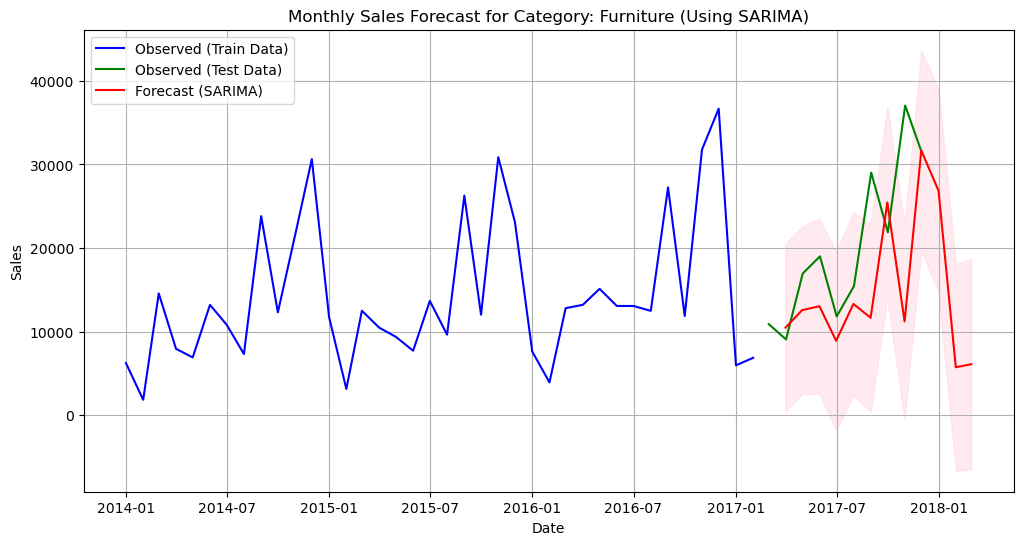

SARIMA Forecast for Furniture - Next 12 Months:
Furniture           mean      mean_se  mean_ci_lower  mean_ci_upper
2017-03-01  10475.766386  5117.885192     444.895733   20506.637039
2017-04-01  12572.654144  5113.619196    2550.144688   22595.163600
2017-05-01  13042.105107  5348.252054    2559.723700   23524.486513
2017-06-01   8901.096213  5459.089571   -1798.522735   19600.715161
2017-07-01  13314.586502  5597.564799    2343.561095   24285.611910
2017-08-01  11655.671187  5723.337749     438.135327   22873.207046
2017-09-01  25454.341645  5848.877284   13990.752820   36917.930471
2017-10-01  11214.575533  5970.645362    -487.674340   22916.825406
2017-11-01  31680.084444  6089.724311   19744.444119   43615.724769
2017-12-01  26857.973515  6205.712557   14695.000405   39020.946625
2018-01-01   5736.713089  6317.978449   -6646.297127   18119.723305
2018-02-01   6102.009753  6428.604168   -6497.822888   18701.842394

Processing Category: Office Supplies


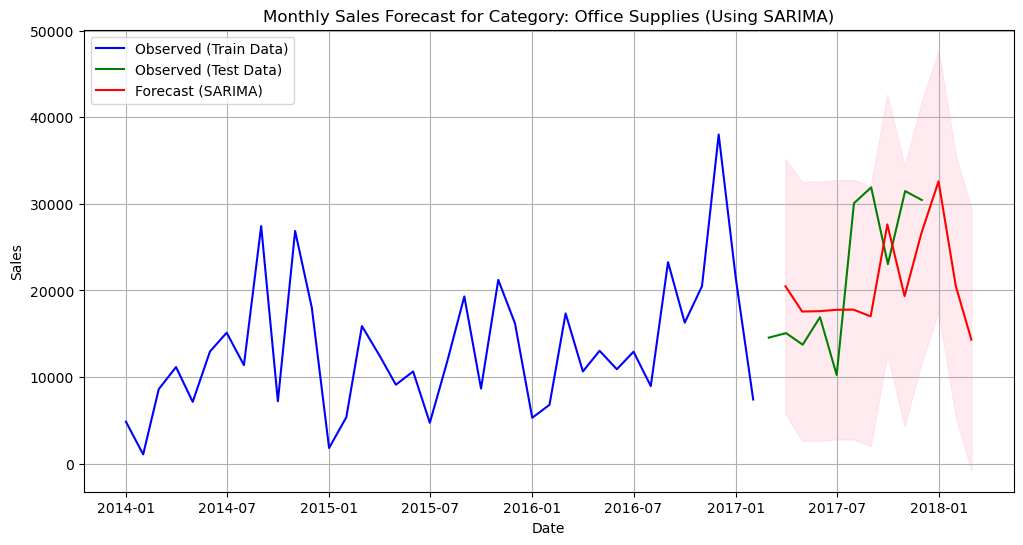

SARIMA Forecast for Office Supplies - Next 12 Months:
Office Supplies          mean      mean_se  mean_ci_lower  mean_ci_upper
2017-03-01       20476.946134  7499.675494    5777.852269   35176.039998
2017-04-01       17562.368236  7621.566539    2624.372314   32500.364158
2017-05-01       17607.316417  7633.382744    2646.161159   32568.471675
2017-06-01       17758.450135  7637.924714    2788.392778   32728.507492
2017-07-01       17786.425286  7642.673046    2807.061369   32765.789203
2017-08-01       17008.491378  7648.627911    2017.456141   31999.526614
2017-09-01       27626.934693  7656.077072   12621.299369   42632.570018
2017-10-01       19344.692133  7665.255625    4321.067177   34368.317090
2017-11-01       26564.883095  7676.438591   11519.339927   41610.426263
2017-12-01       32598.780077  7689.959470   17526.736473   47670.823682
2018-01-01       20510.102436  7704.780643    5409.009866   35611.195006
2018-02-01       14310.580738  7715.493157    -811.507973   29432.6694

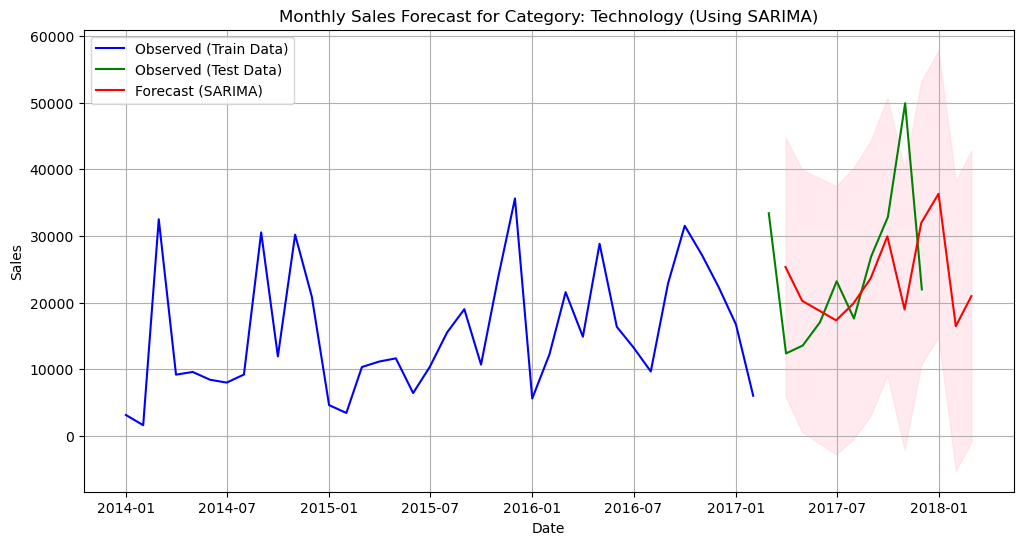

SARIMA Forecast for Technology - Next 12 Months:
Technology          mean       mean_se  mean_ci_lower  mean_ci_upper
2017-03-01  25348.393003   9891.310417    5961.780825   44735.005181
2017-04-01  20268.214638  10035.562525     598.873524   39937.555752
2017-05-01  18789.662255  10152.359566   -1108.596852   38687.921361
2017-06-01  17342.687897  10267.726257   -2781.685769   37467.061563
2017-07-01  19871.443974  10382.323062    -477.535305   40220.423252
2017-08-01  23641.337647  10496.379116    3068.812611   44213.862683
2017-09-01  29945.499407  10610.150600    9149.986360   50741.012453
2017-10-01  18977.423066  10723.944122   -2041.121185   39995.967317
2017-11-01  31995.810399  10838.134283   10753.457543   53238.163254
2017-12-01  36336.211560  10953.184443   14868.364536   57804.058584
2018-01-01  16466.502191  11064.370233   -5219.264977   38152.269358
2018-02-01  20978.696134  11170.927009    -915.918477   42873.310745


In [77]:
# Looping through each category for SARIMA modeling and forecasting
for category in monthly_category_sales.columns:
    print(f"\nProcessing Category: {category}")

    # Collecting sales data for the current category
    category_sales = monthly_category_sales[category].dropna()  # Drop missing values if any

    # Splitting sales data into training and testing sets for the current category
    train_category = category_sales.iloc[:split_index]
    test_category = category_sales.iloc[split_index:]

    # Fitting SARIMA model on training data
    sarima_model = SARIMAX(train_category,
                           order=(1, 1, 1),  
                           seasonal_order=(1, 1, 1, 12),  
                           enforce_stationarity=False,
                           enforce_invertibility=False)

    sarima_result = sarima_model.fit()

    # Forecasting for the next 12 months
    forecast_steps = 12
    sarima_forecast = sarima_result.get_forecast(steps=forecast_steps)
    sarima_forecast_index = pd.date_range(start=test_category.index[0], periods=forecast_steps, freq='M')

    # Visualizing forecasted sales data using SARIMA model
    plt.figure(figsize=(12, 6))
    plt.plot(train_category, label='Observed (Train Data)', color='blue')
    plt.plot(test_category, label='Observed (Test Data)', color='green')
    plt.plot(sarima_forecast_index, sarima_forecast.predicted_mean, label='Forecast (SARIMA)', color='red')
    plt.fill_between(sarima_forecast_index,
                     sarima_forecast.conf_int().iloc[:, 0],
                     sarima_forecast.conf_int().iloc[:, 1], color='pink', alpha=0.3)
    plt.title(f'Monthly Sales Forecast for Category: {category} (Using SARIMA)')
    plt.xlabel('Date')
    plt.ylabel('Sales')
    plt.legend()
    plt.grid()
    plt.show()

    # Displaying forecasted values
    forecast_summary = sarima_forecast.summary_frame()
    print(f"SARIMA Forecast for {category} - Next {forecast_steps} Months:")
    print(forecast_summary)



Sales Trends

Seasonal Patterns Captured:

Both SARIMA and Prophet models effectively captured seasonal patterns in the sales data:

>Furniture: The SARIMA model predicted peak sales in September 2017 (25,454.34) and low sales in January 2018 (5,736.71). The Prophet model also highlighted a peak in October 2017 (30,647.39) and a drop in January 2018 (7,521.68).

>Office Supplies: SARIMA identified a notable peak in September 2017 (27,626.93), while Prophet forecasted the highest sales in October 2017 (39,235.97).

>Technology: SARIMA showed a peak in September 2017 (29,945.50), with low sales in June 2017 (17,342.69). The Prophet model similarly forecasted high sales in October 2017 (32,026.75).

Confidence Intervals:

Confidence intervals provided by the models help assess risks and uncertainties. For example:

>Furniture:
SARIMA for October 2017 predicted a mean of 11,214.58, with a lower bound of -487.67 and an upper bound of 22,916.83.
Prophet for October 2017 forecasted 30,647.39, with a lower bound of 28,241.50 and an upper bound of 33,007.42.

>Office Supplies:
SARIMA for October 2017 predicted a mean of 19,344.69, with a lower bound of 4,321.07 and an upper bound of 34,368.32.
Prophet for October 2017 forecasted 39,235.97, with a lower bound of 34,997.18 and an upper bound of 43,357.21.

>Technology:
SARIMA for October 2017 predicted a mean of 18,977.42, with a lower bound of -2,041.12 and an upper bound of 39,995.97.
Prophet for October 2017 forecasted 32,026.75, with a lower bound of 26,864.70 and an upper bound of 36,946.07.

Category-Wise Trends:

>Furniture: Demonstrated peaks in September and October 2017, signaling strong seasonal demand. There was a notable drop in sales during January 2018, aligning with post-holiday slowdowns.

>Office Supplies: Displayed a steady pattern, with notable peaks in August and October 2017. Seasonal demand likely correlates with back-to-school and holiday preparations.

>Technology: Showed consistent growth with notable peaks in August and October 2017, likely driven by increased demand for technology products during back-to-school and holiday seasons.

5. Model Comparison

    5.1 Evaluation Metrics

>Calculate evaluation metrics for each model:

>>Mean Absolute Error (MAE)

>>Mean Squared Error (MSE)

>>Root Mean Squared Error (RMSE)

>>Mean Absolute Percentage Error (MAPE)

>Compare metrics across ARIMA, Prophet, and SARIMA models for both overall and category-specific forecasts.

    5.2 Performance Metrics Comparison

>Tabulate performance metrics for all categories and models.

>Visualize MAPE comparison using bar charts for ARIMA, Prophet, and SARIMA models across all categories.

>Identify the best-performing model for each category based on RMSE and MAPE.

    5.3 Error Analysis

>Analyze the error distribution for each model to evaluate prediction reliability.

>Visualize error histograms to identify any bias or systemic issues in forecasts.

>Residual analysis performed to ensure minimal autocorrelation in errors.

    5.4 Improvement Analysis

>Compare each model’s RMSE to the baseline (ARIMA).

>Quantified percentage improvement for Prophet and SARIMA over ARIMA for both overall and category-specific forecasts.


Processing Category: Furniture


15:25:09 - cmdstanpy - INFO - Chain [1] start processing
15:25:09 - cmdstanpy - INFO - Chain [1] done processing
15:25:09 - cmdstanpy - INFO - Chain [1] start processing



Processing Category: Office Supplies


15:25:10 - cmdstanpy - INFO - Chain [1] done processing
15:25:10 - cmdstanpy - INFO - Chain [1] start processing



Processing Category: Technology


15:25:10 - cmdstanpy - INFO - Chain [1] done processing



Performance Metrics Comparison:
          Category    ARIMA_MAE     ARIMA_MSE    ARIMA_RMSE  ARIMA_MAPE  \
0        Furniture  7542.549165  1.023611e+08  10117.364756   33.775737   
1  Office Supplies  7533.817968  8.766716e+07   9363.074218   31.999175   
2       Technology  9559.678822  1.826095e+08  13513.309241   31.724230   

   Prophet_MAE   Prophet_MSE  Prophet_RMSE  Prophet_MAPE   SARIMA_MAE  \
0  4013.804893  1.956785e+07   4423.555711     23.721072  4740.456622   
1  4884.033298  4.563414e+07   6755.304364     22.816088  4876.061899   
2  6685.061406  6.696087e+07   8182.961945     28.239641  7998.577696   

     SARIMA_MSE  SARIMA_RMSE  SARIMA_MAPE  Prophet_RMSE_Improvement  \
0  3.227702e+07  5681.286496    24.606809                 56.277590   
1  3.449015e+07  5872.831500    25.962994                 27.851641   
2  9.310478e+07  9649.082034    33.112554                 39.445166   

   SARIMA_RMSE_Improvement  
0                43.846183  
1                37.276675  
2

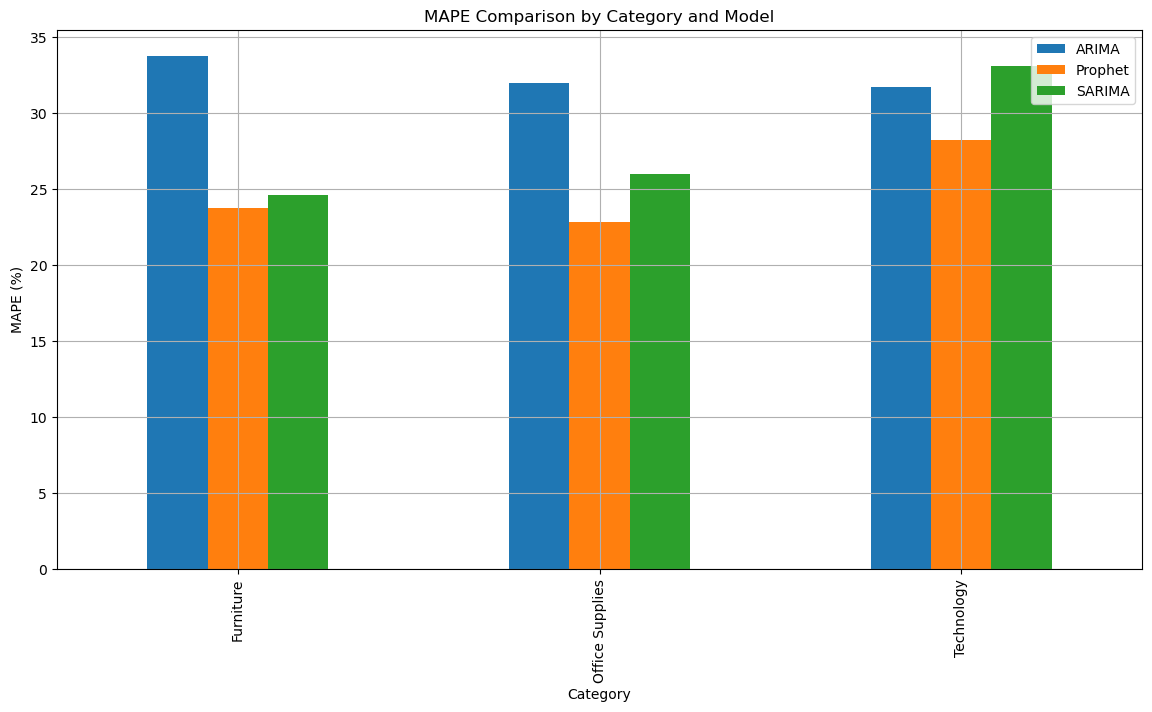

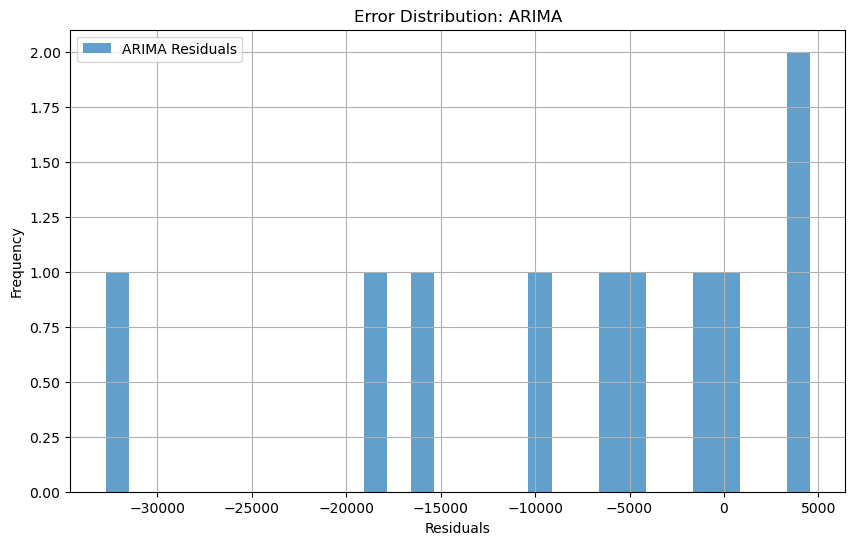


Residuals for ARIMA
2017-03-01   -17850.788912
2017-04-01     4559.135513
2017-05-01     3570.931315
2017-06-01      104.281884
2017-07-01    -6040.562909
2017-08-01     -449.230045
2017-09-01    -9772.589761
2017-10-01   -15685.638147
2017-11-01   -32748.746488
2017-12-01    -4814.883250
Freq: MS, dtype: float64


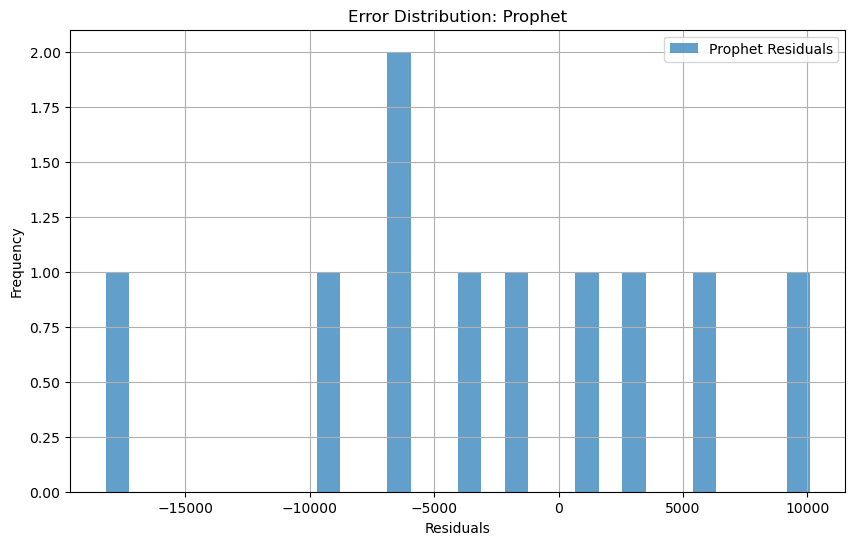


Residuals for Prophet
Order Date
2017-03-01    -6872.063946
2017-04-01     3463.090443
2017-05-01    10111.375233
2017-06-01    -1721.052353
2017-07-01    -9041.708786
2017-08-01    -4033.867857
2017-09-01     1243.023974
2017-10-01    -5955.091937
2017-11-01   -18214.982941
2017-12-01     6194.356586
Freq: MS, Name: Technology, dtype: float64


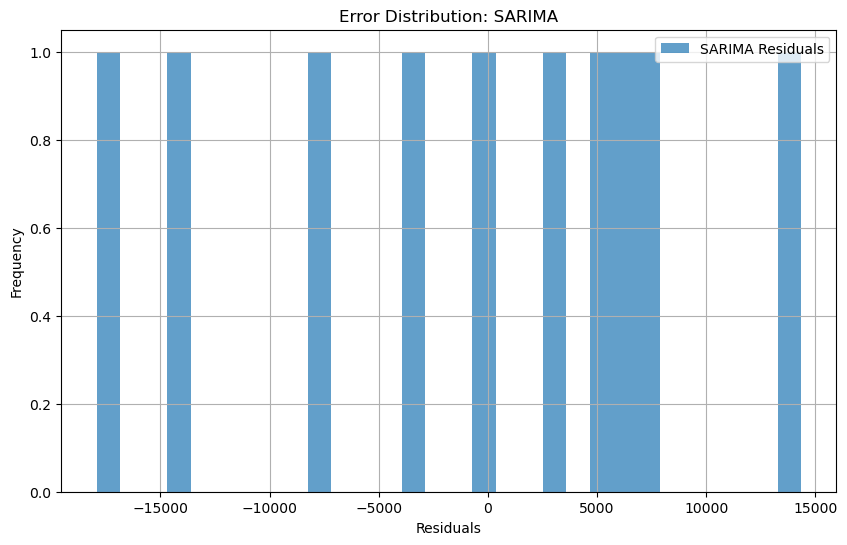


Residuals for SARIMA
2017-03-01    -8080.228997
2017-04-01     7884.827638
2017-05-01     5223.074255
2017-06-01      281.587897
2017-07-01    -3338.482026
2017-08-01     6022.175647
2017-09-01     3002.896407
2017-10-01   -13878.239934
2017-11-01   -17922.962601
2017-12-01    14351.301560
Freq: MS, dtype: float64


In [81]:
# Initializing a DataFrame to store performance metrics for each category
performance_metrics = []

# Looping through each category
for category in monthly_category_sales.columns:
    print(f"\nProcessing Category: {category}")

    # Collecting sales data for the current category
    category_sales = monthly_category_sales[category].dropna()

    # Splitting sales data into training and testing sets for the current category
    train_category = category_sales.iloc[:split_index]
    test_category = category_sales.iloc[split_index:]

    # --- ARIMA Model ---
    arima_model = ARIMA(train_category, order=(1, 1, 1))
    arima_result = arima_model.fit()
    arima_forecast = arima_result.get_forecast(steps=len(test_category))
    arima_pred = arima_forecast.predicted_mean

    # --- Prophet Model ---
    prophet_data = train_category.reset_index()
    prophet_data.columns = ['ds', 'y']
    prophet_model = Prophet()
    prophet_model.fit(prophet_data)
    future_dates = pd.DataFrame({'ds': test_category.index})
    prophet_forecast = prophet_model.predict(future_dates)
    prophet_pred = prophet_forecast['yhat'].values

    # --- SARIMA Model ---
    sarima_model = SARIMAX(train_category,
                           order=(1, 1, 1),
                           seasonal_order=(1, 1, 1, 12),
                           enforce_stationarity=False,
                           enforce_invertibility=False)
    sarima_result = sarima_model.fit()
    sarima_forecast = sarima_result.get_forecast(steps=len(test_category))
    sarima_pred = sarima_forecast.predicted_mean

    # --- Calculating Error Metrics ---
    def calculate_metrics(actual, predicted):
        mae = mean_absolute_error(actual, predicted)
        mse = mean_squared_error(actual, predicted)
        rmse = mse ** 0.5
        mape = (abs((actual - predicted) / actual).mean()) * 100
        return mae, mse, rmse, mape

    arima_mae, arima_mse, arima_rmse, arima_mape = calculate_metrics(test_category, arima_pred)
    prophet_mae, prophet_mse, prophet_rmse, prophet_mape = calculate_metrics(test_category, prophet_pred)
    sarima_mae, sarima_mse, sarima_rmse, sarima_mape = calculate_metrics(test_category, sarima_pred)

    # Adding metrics to the performance_metrics list
    performance_metrics.append({
        'Category': category,
        'ARIMA_MAE': arima_mae,
        'ARIMA_MSE': arima_mse,
        'ARIMA_RMSE': arima_rmse,
        'ARIMA_MAPE': arima_mape,
        'Prophet_MAE': prophet_mae,
        'Prophet_MSE': prophet_mse,
        'Prophet_RMSE': prophet_rmse,
        'Prophet_MAPE': prophet_mape,
        'SARIMA_MAE': sarima_mae,
        'SARIMA_MSE': sarima_mse,
        'SARIMA_RMSE': sarima_rmse,
        'SARIMA_MAPE': sarima_mape
    })

# Converting performance metrics into a DataFrame
performance_df = pd.DataFrame(performance_metrics)

# Comparing RMSE improvements over ARIMA
performance_df['Prophet_RMSE_Improvement'] = ((performance_df['ARIMA_RMSE'] - performance_df['Prophet_RMSE']) /
                                              performance_df['ARIMA_RMSE']) * 100
performance_df['SARIMA_RMSE_Improvement'] = ((performance_df['ARIMA_RMSE'] - performance_df['SARIMA_RMSE']) /
                                             performance_df['ARIMA_RMSE']) * 100

print("\nPerformance Metrics Comparison:")
print(performance_df)

# Plotting a comparison of MAPE for each category and model
performance_df.set_index('Category')[['ARIMA_MAPE', 'Prophet_MAPE', 'SARIMA_MAPE']].plot(kind='bar', figsize=(14, 7))
plt.title("MAPE Comparison by Category and Model")
plt.ylabel("MAPE (%)")
plt.xlabel("Category")
plt.legend(["ARIMA", "Prophet", "SARIMA"])
plt.grid()
plt.show()

# Plotting residuals for error analysis
for model, errors in {'ARIMA': arima_pred - test_category, 
                      'Prophet': prophet_pred - test_category, 
                      'SARIMA': sarima_pred - test_category}.items():
    plt.figure(figsize=(10, 6))
    plt.hist(errors, bins=30, alpha=0.7, label=f"{model} Residuals")
    plt.title(f"Error Distribution: {model}")
    plt.xlabel("Residuals")
    plt.ylabel("Frequency")
    plt.legend()
    plt.grid()
    plt.show()

    print(f"\nResiduals for {model}")
    print(errors)

Forecast Performance

Overall Performance:

>Prophet was the best-performing model across all categories, demonstrating the lowest RMSE and MAPE, indicating its superior accuracy in capturing trends. SARIMA followed as a close second, showing strong consistency and lower error metrics than ARIMA.
Category-Specific Insights:

Furniture:

>Prophet: RMSE = 4,423.56, MAPE = 23.72%

>SARIMA: RMSE = 5,681.29, MAPE = 24.61%

>ARIMA: RMSE = 10,117.36, MAPE = 33.78%

Office Supplies:

>Prophet: RMSE = 6,755.30, MAPE = 22.82%

>SARIMA: RMSE = 5,872.83, MAPE = 25.96%

>ARIMA: RMSE = 9,363.07, MAPE = 32.00%

Technology:

>Prophet: RMSE = 8,182.96, MAPE = 28.24%

>SARIMA: RMSE = 9,649.08, MAPE = 33.11%

>ARIMA: RMSE = 13,513.31, MAPE = 31.72%

Improvements Over ARIMA:

Prophet RMSE Improvement:

>Furniture: 56.28%

>Office Supplies: 27.85%

>Technology: 39.45%

SARIMA RMSE Improvement:

>Furniture: 43.85%

>Office Supplies: 37.28%

>Technology: 28.60%

Conclusion:

The results demonstrate that Prophet consistently achieved the best overall performance, with significant reductions in RMSE and MAPE across all categories. SARIMA also performed well, especially in terms of stability and consistency, showing marked improvement over ARIMA. While ARIMA lagged behind both models in all metrics, it provided a baseline for evaluating advanced forecasting techniques. For future implementations, Prophet is recommended for applications requiring trend sensitivity, while SARIMA is suitable for capturing seasonal patterns with moderate error tolerances.

Error Analysis

SARIMA:

The residuals for SARIMA display a mix of positive and negative values, indicating variability in predictions. For example:

>A significant negative residual of -8,080.23 in March 2017.

>A positive residual of 14,351.30 in December 2017.

Performance Metrics:

>RMSE: 5,681.29, better than ARIMA (10,117.36) but higher than Prophet (4,423.56).

>MAPE: 24.61%, better than ARIMA (33.78%) but higher than Prophet (23.72%).

These results suggest that SARIMA performed well overall, showing lower RMSE and MAPE compared to ARIMA. However, its residuals indicate some variability, with errors occasionally deviating significantly in magnitude.

Prophet:

Prophet's residuals also show variability with both negative and positive errors. Notable examples include:

>A negative residual of -6,872.06 in March 2017.

>A positive residual of 6,194.36 in December 2017.

Performance Metrics:

>RMSE: 4,423.56, the lowest among all models, indicating the best accuracy overall.

>MAPE: 23.72%, the lowest, highlighting Prophet's effectiveness in minimizing percentage errors.

Prophet excelled in accuracy, achieving the lowest RMSE and MAPE. It effectively captured growth trends while maintaining low residuals, making it the most reliable model for trend-sensitive forecasting.

ARIMA:

ARIMA's residuals consistently exhibit larger errors, especially negative ones in the earlier months, such as:

>-17,850.79 in March 2017.

>-32,748.75 in November 2017.

Performance Metrics:

>RMSE: 10,117.36, the highest among all models, indicating poor accuracy.

>MAPE: 33.78%, significantly higher than both Prophet and SARIMA.

ARIMA underperformed across all metrics, with large residuals and higher error rates. Its inability to effectively capture trends and variability in the data makes it the least suitable model for the dataset.

Summary:

>Prophet demonstrated the best overall performance, with the lowest RMSE and MAPE, making it the most accurate and reliable model for trend-sensitive forecasting.

>SARIMA followed closely, showing strong consistency and moderate accuracy, making it suitable for scenarios prioritizing stability.

>ARIMA lagged significantly, with high RMSE and MAPE, making it the least effective model.

>>>>Forecasting Sales Region-wise

Workflow Steps
1. Data Preparation
   
    1.1 Convert the "Order Date" column to datetime format.

    1.2 Aggregate monthly sales data by region and month to enable region-specific analysis.


1.1 Converting the "Order Date" to datetime format

In [88]:
orders_data['Order Date'] = pd.to_datetime(orders_data['Order Date'])

1.2 Aggregating monthly sales data by region and month

In [91]:
monthly_region_sales = (
    orders_data.groupby([orders_data['Order Date'].dt.to_period('M'), 'Region'])['Sales']
    .sum()
    .unstack()  # Pivot to create columns for each region
)

2. Exploratory Data Analysis (EDA)

    2.1 Visualize the aggregated monthly sales data by region to identify trends and patterns.
        
    2.2 Observe growth trends over time for each region.
        
    2.3 Generate region-wise monthly sales visualizations to identify individual region trends.

2.1 Visualizing the aggregated monthly sales data by region 

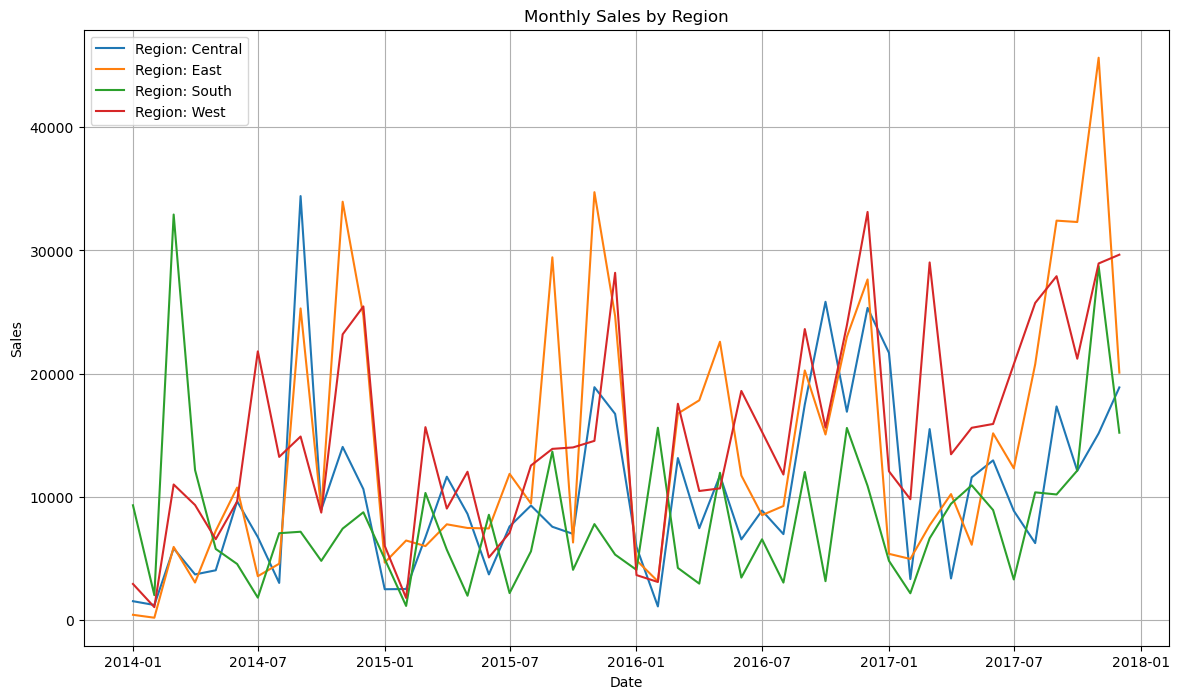

Region-wise Monthly Sales Data:
Region       Central      East      South       West
Order Date                                          
2014-01-01  1539.906   436.174   9322.092   2938.723
2014-02-01  1233.174   199.776   2028.986   1057.956
2014-03-01  5827.602  5943.388  32911.121  11008.898
2014-04-01  3712.340  3054.906  12184.612   9343.487
2014-05-01  4048.506  7250.103   5779.240   6570.438


In [94]:
# Converting the index back to timestamp for plotting
monthly_region_sales.index = monthly_region_sales.index.to_timestamp()

# Visualizing monthly sales data for each region
plt.figure(figsize=(14, 8))
for region in monthly_region_sales.columns:
    plt.plot(monthly_region_sales.index, monthly_region_sales[region], label=f'Region: {region}')

plt.title('Monthly Sales by Region')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.legend()
plt.grid()
plt.show()

print("Region-wise Monthly Sales Data:")
print(monthly_region_sales.head())

2.2 Observe growth trends over time for each region


Analyzing Growth Trend for Region: Central


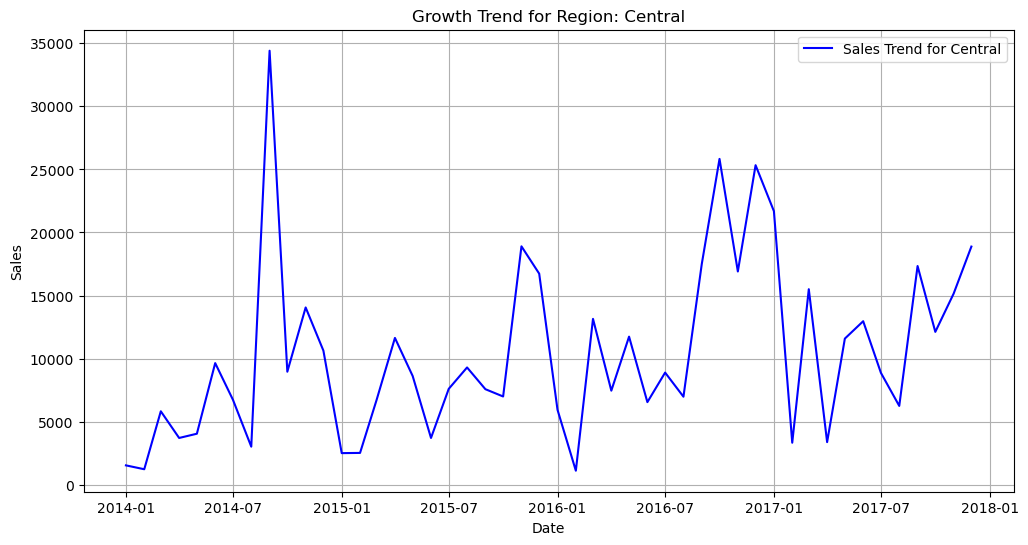

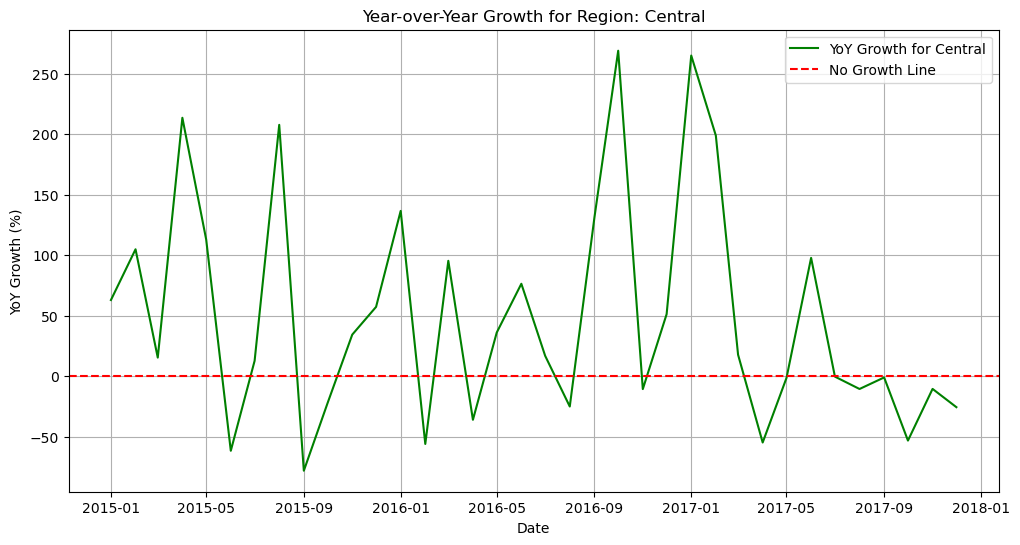

Summary of Year-over-Year Growth for Central:
Mean YoY Growth: 49.17%
Max YoY Growth: 269.01%
Min YoY Growth: -77.97%


Analyzing Growth Trend for Region: East


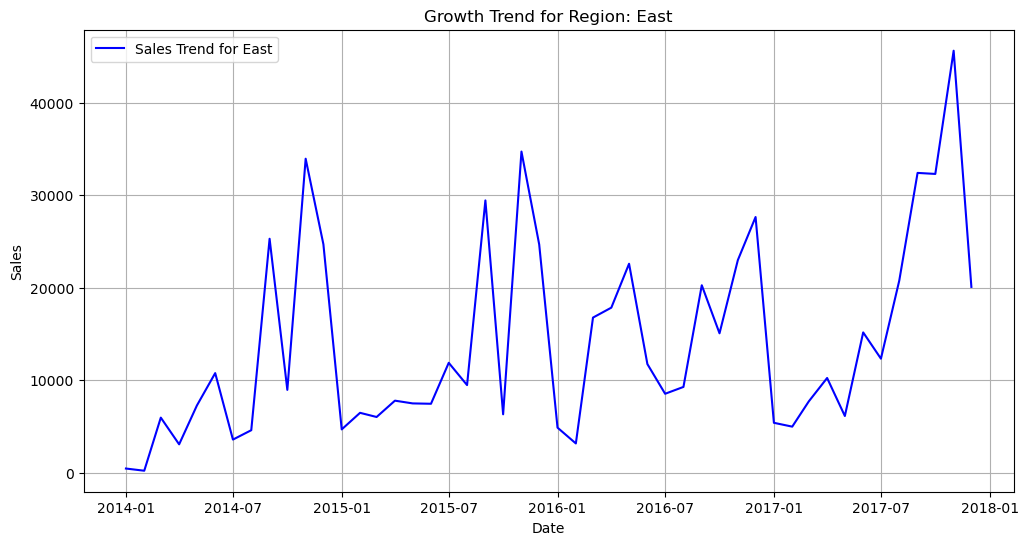

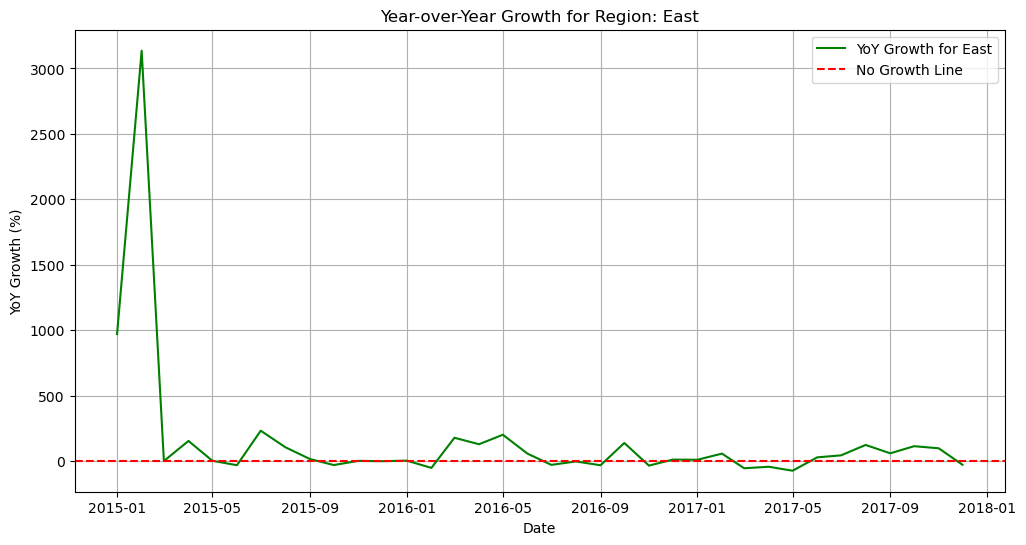

Summary of Year-over-Year Growth for East:
Mean YoY Growth: 152.26%
Max YoY Growth: 3135.19%
Min YoY Growth: -72.91%


Analyzing Growth Trend for Region: South


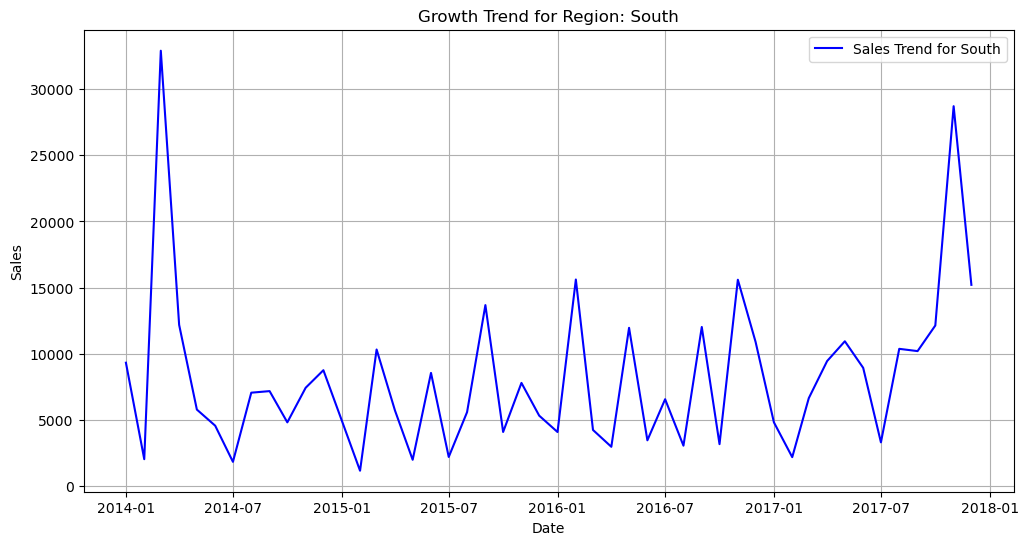

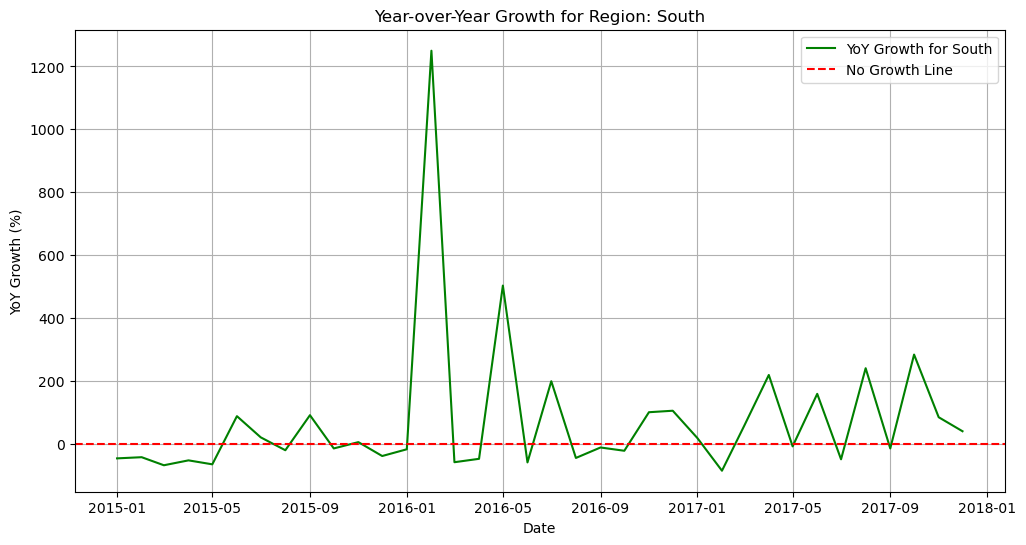

Summary of Year-over-Year Growth for South:
Mean YoY Growth: 74.52%
Max YoY Growth: 1250.01%
Min YoY Growth: -86.02%


Analyzing Growth Trend for Region: West


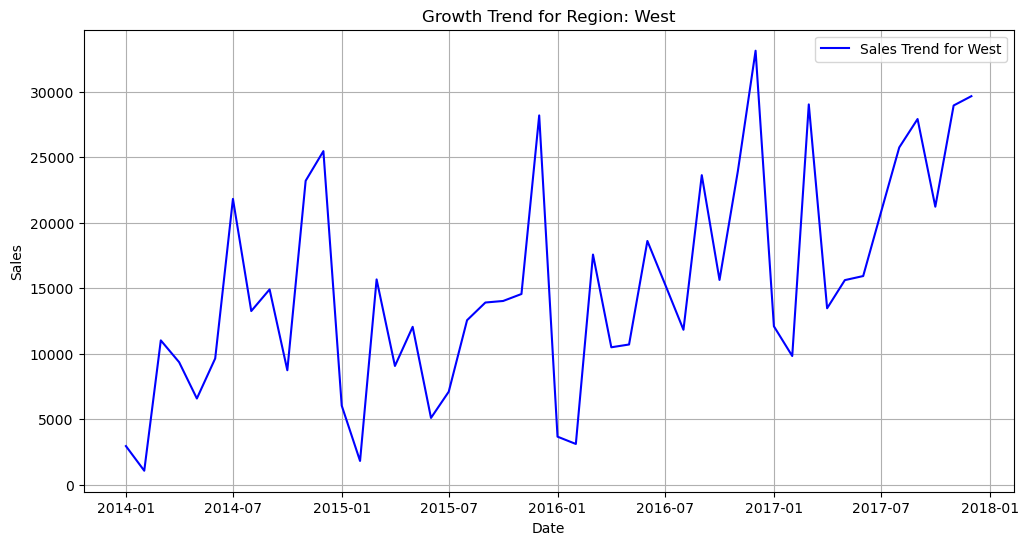

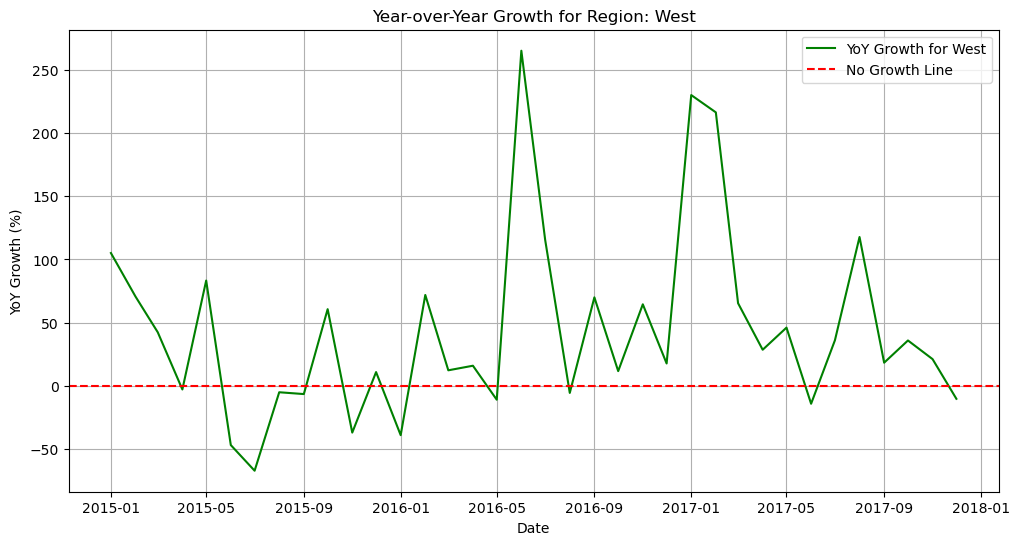

Summary of Year-over-Year Growth for West:
Mean YoY Growth: 43.99%
Max YoY Growth: 265.46%
Min YoY Growth: -67.49%



In [97]:
# Loopingthrough each region to analyze growth trends
for region in monthly_region_sales.columns:
    print(f"\nAnalyzing Growth Trend for Region: {region}")
    
    # Extracting sales data for the current region
    region_sales = monthly_region_sales[region].dropna()  # Drop missing values if any
    
    # Plotting the sales trend for the region
    plt.figure(figsize=(12, 6))
    plt.plot(region_sales.index, region_sales, label=f'Sales Trend for {region}', color='blue')
    plt.title(f'Growth Trend for Region: {region}')
    plt.xlabel('Date')
    plt.ylabel('Sales')
    plt.grid()
    plt.legend()
    plt.show()
    
    # Calculating year-over-year growth 
    if len(region_sales) > 12:  
        yoy_growth = region_sales.pct_change(periods=12) * 100 
        
        # Plotting Year-over-Year Growth
        plt.figure(figsize=(12, 6))
        plt.plot(yoy_growth.index, yoy_growth, label=f'YoY Growth for {region}', color='green')
        plt.axhline(0, color='red', linestyle='--', label='No Growth Line')
        plt.title(f'Year-over-Year Growth for Region: {region}')
        plt.xlabel('Date')
        plt.ylabel('YoY Growth (%)')
        plt.grid()
        plt.legend()
        plt.show()
        
        print(f"Summary of Year-over-Year Growth for {region}:")
        print(f"Mean YoY Growth: {yoy_growth.mean():.2f}%")
        print(f"Max YoY Growth: {yoy_growth.max():.2f}%")
        print(f"Min YoY Growth: {yoy_growth.min():.2f}%\n")
    else:
        print(f"Not enough data points to calculate Year-over-Year Growth for {region}.")


Analysis of Regional Growth Trends

The Year-over-Year (YoY) growth trends across different regions—Central, East, South, and West—highlight varying patterns of growth, with significant differences in mean, maximum, and minimum growth rates. Below is a summary of the insights derived from the analysis:

Central Region
   
>Mean YoY Growth: 49.17%

>>The Central region exhibits moderate average growth, indicating a steady upward trend.

>Max YoY Growth: 269.01%

>>The maximum growth suggests occasional high-performing periods.

>Min YoY Growth: -77.97%

>>A sharp decline in certain periods indicates volatility and challenges in maintaining consistent growth.

East Region

>Mean YoY Growth: 152.26%

>>The East region demonstrates the highest average growth among all regions, reflecting strong and consistent performance.

>Max YoY Growth: 3135.19%

>>Exceptional spikes in growth highlight extraordinary periods of performance, potentially driven by market expansions or new initiatives.

>Min YoY Growth: -72.91%

>>Periodic setbacks indicate some instability, though the overall trend remains robust.

South Region

>Mean YoY Growth: 74.52%

>>The South region shows healthy average growth, with consistent positive momentum.

>Max YoY Growth: 1250.01%

>>Substantial growth peaks signify moments of rapid expansion or favorable market conditions.

>Min YoY Growth: -86.02%

>>The region experienced significant downturns during certain periods, suggesting the need for better risk management.

West Region

>Mean YoY Growth: 43.99%

>>The West region reports the lowest average growth, pointing to slower yet stable progress.

>Max YoY Growth: 265.46%

>>Moderate spikes in growth indicate limited but impactful periods of higher performance.

>Min YoY Growth: -67.49%

>>Downturns remain less severe compared to other regions, reflecting better resilience.

Insights:

>The East region stands out with exceptional YoY growth metrics, making it a top performer.

>The Central and South regions display moderate but steady growth trends, with occasional spikes.

>The West region is characterized by slower growth but demonstrates better stability with fewer drastic declines.

>Periodic downturns in all regions highlight opportunities for improved strategy and risk mitigation to ensure sustained growth

2.3 Generating region-wise monthly sales visualizations

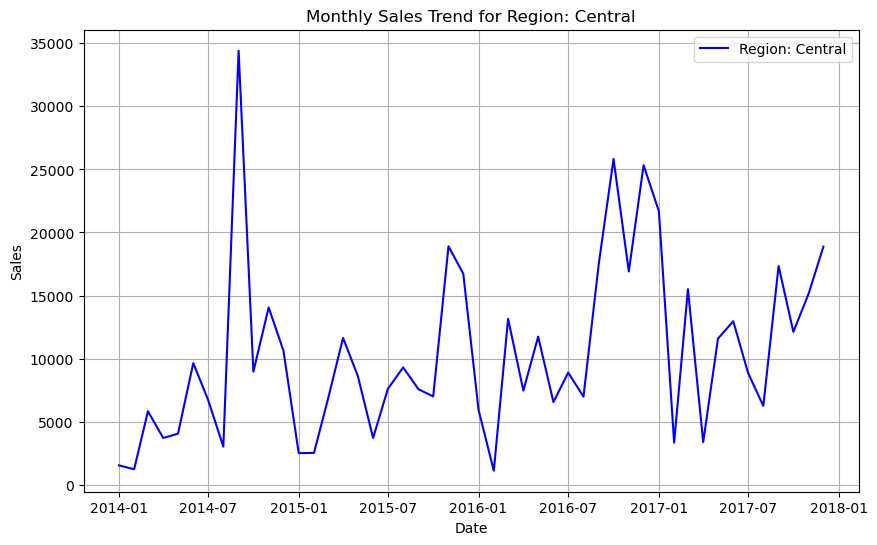

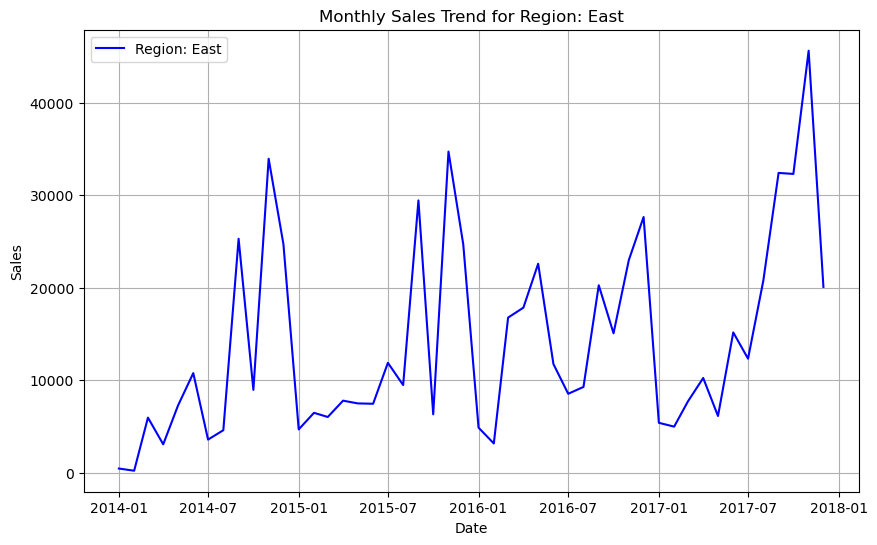

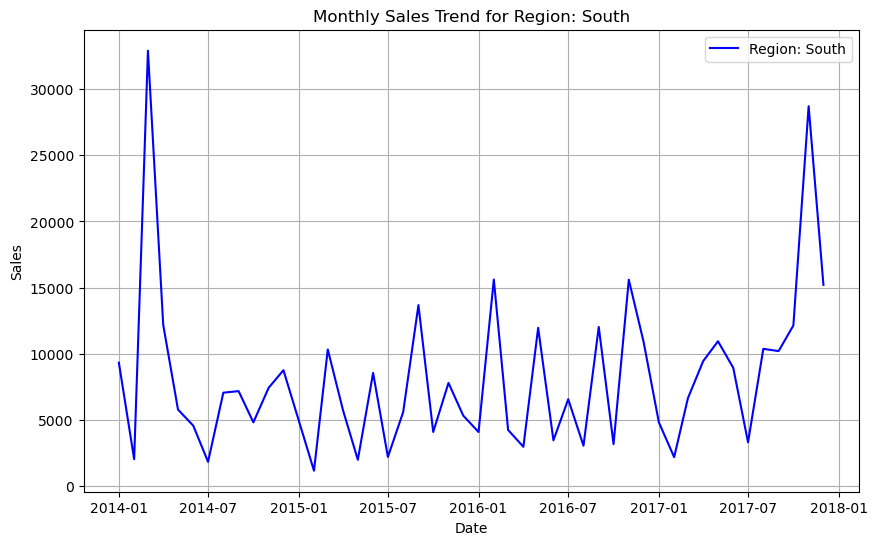

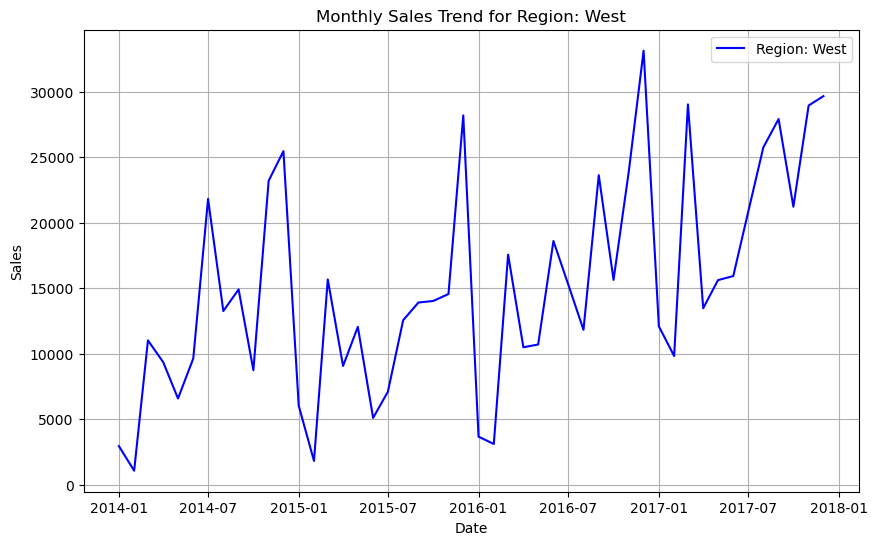

In [101]:
for region in monthly_region_sales.columns:
    plt.figure(figsize=(10, 6))
    plt.plot(monthly_region_sales.index, monthly_region_sales[region], label=f'Region: {region}', color='blue')
    plt.title(f'Monthly Sales Trend for Region: {region}')
    plt.xlabel('Date')
    plt.ylabel('Sales')
    plt.legend()
    plt.grid()
    plt.show()

3. Data Splitting

    3.1 Split the time series into training (80%) and test (20%) sets and make sure the data split preserves chronological order to maintain the integrity of time series analysis.

3.1 Splitting Data into Train and Test Sets


Processing Region: Central
Training Data Range for Central: 2014-01-01 00:00:00 to 2017-02-01 00:00:00
Test Data Range for Central: 2017-03-01 00:00:00 to 2017-12-01 00:00:00


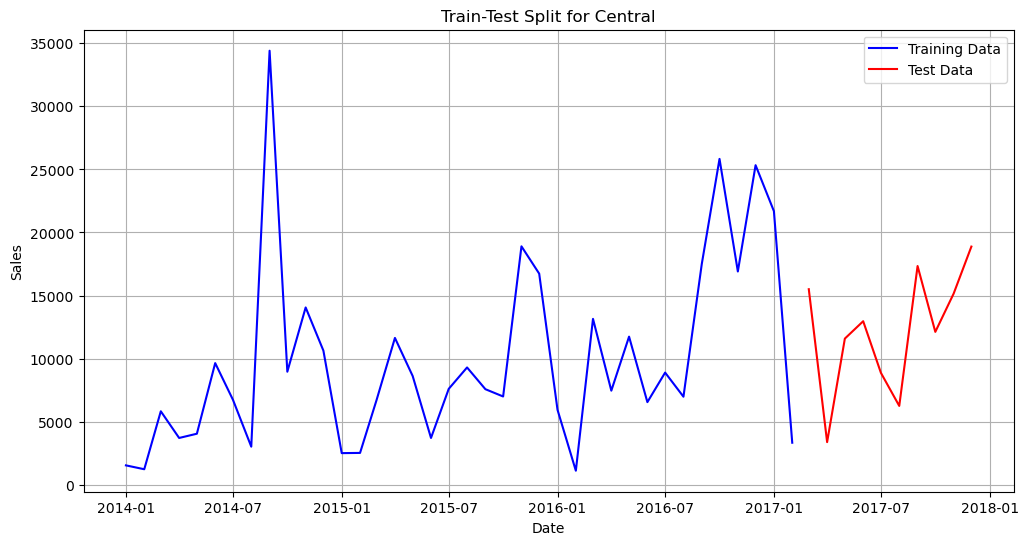


Processing Region: East
Training Data Range for East: 2014-01-01 00:00:00 to 2017-02-01 00:00:00
Test Data Range for East: 2017-03-01 00:00:00 to 2017-12-01 00:00:00


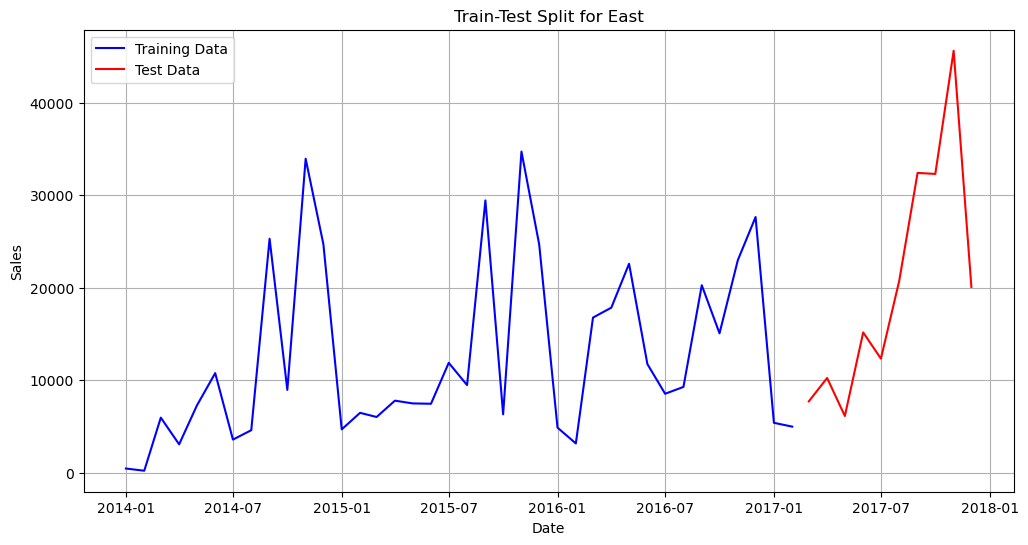


Processing Region: South
Training Data Range for South: 2014-01-01 00:00:00 to 2017-02-01 00:00:00
Test Data Range for South: 2017-03-01 00:00:00 to 2017-12-01 00:00:00


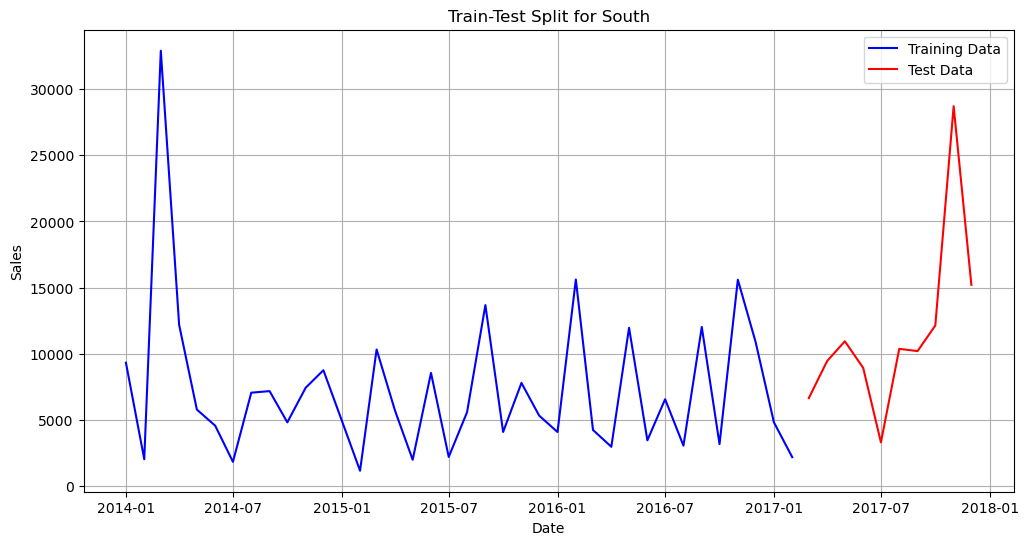


Processing Region: West
Training Data Range for West: 2014-01-01 00:00:00 to 2017-02-01 00:00:00
Test Data Range for West: 2017-03-01 00:00:00 to 2017-12-01 00:00:00


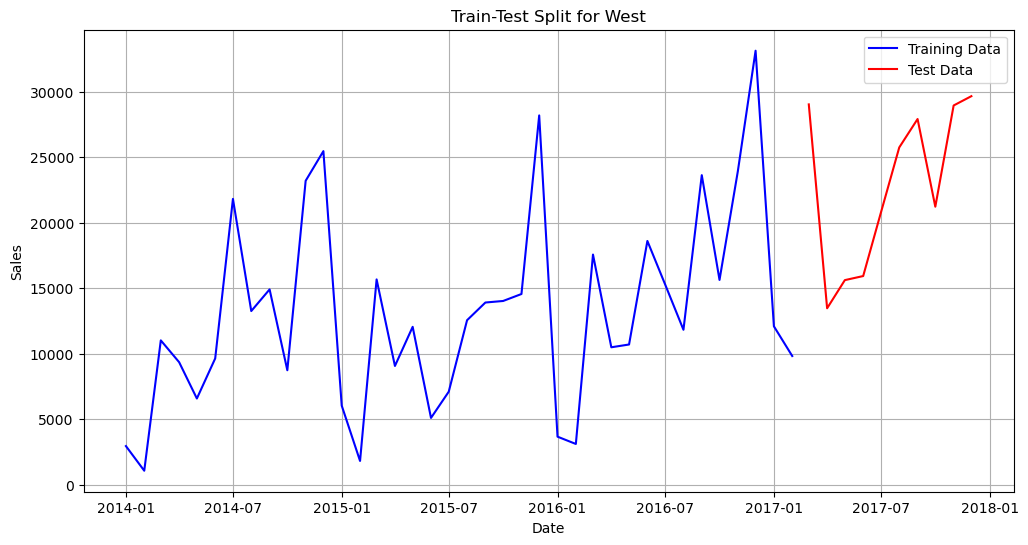

In [105]:
# Splitting data into train and test sets for each region
for region in monthly_region_sales.columns:
    print(f"\nProcessing Region: {region}")
    
    # Extract sales data for the current region
    region_sales = monthly_region_sales[region]
    
    # Calculate split index (80% training, 20% testing)
    split_ratio = 0.8
    split_index = int(len(region_sales) * split_ratio)
    
    # Training data: first 80%
    train_data = region_sales.iloc[:split_index]
    
    # Testing data: remaining 20%
    test_data = region_sales.iloc[split_index:]
    
    # Printing the date range for both training and test data
    print(f"Training Data Range for {region}:", train_data.index.min(), "to", train_data.index.max())
    print(f"Test Data Range for {region}:", test_data.index.min(), "to", test_data.index.max())
    
    # Visualize the split
    plt.figure(figsize=(12, 6))
    plt.plot(train_data.index, train_data, label='Training Data', color='blue')
    plt.plot(test_data.index, test_data, label='Test Data', color='red')
    plt.title(f'Train-Test Split for {region}')
    plt.xlabel('Date')
    plt.ylabel('Sales')
    plt.legend()
    plt.grid()
    plt.show()

4. Forecasting Models

    4.1 ARIMA Model
>Fit an ARIMA(1,1,1) model to the training data for overall and region-specific sales.

>Forecast sales 12 months into the future with confidence intervals.

>Visualize forecast performance compared to the test set.

>Display forecasted values for each region for better interpretability


Processing Region: Central
Training Data Range: 2014-01-01 00:00:00 to 2017-02-01 00:00:00
Test Data Range: 2017-03-01 00:00:00 to 2017-12-01 00:00:00


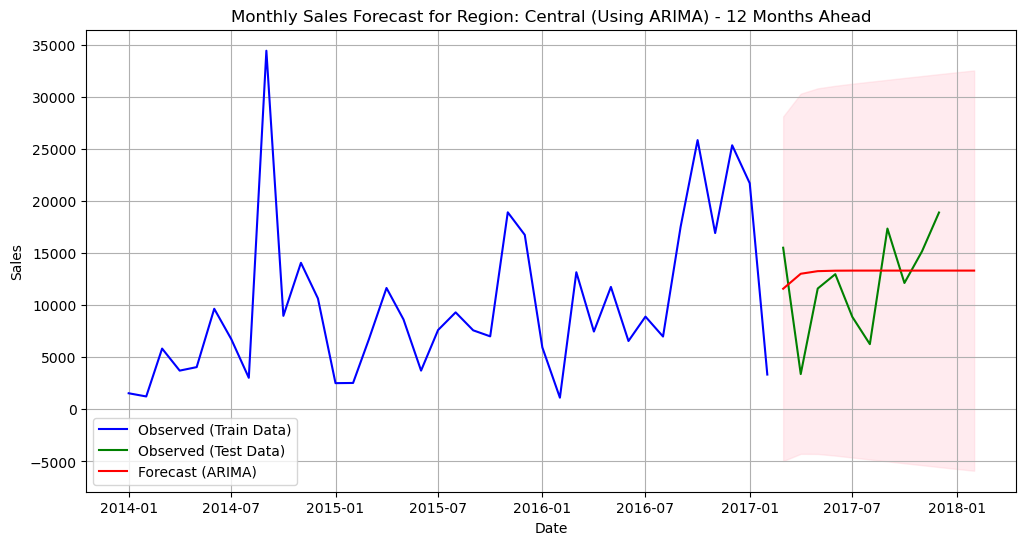

ARIMA Forecast for Central - Next 12 Months:
Central             mean      mean_se  mean_ci_lower  mean_ci_upper
2017-03-01  11570.707485  8434.502112   -4960.612882   28102.027852
2017-04-01  13006.771442  8815.642184   -4271.569739   30285.112622
2017-05-01  13257.173149  8949.229523   -4282.994406   30797.340704
2017-06-01  13300.834864  9052.281847   -4441.311535   31042.981263
2017-07-01  13308.448012  9149.595298   -4624.429244   31241.325269
2017-08-01  13309.775492  9245.104986   -4810.297315   31429.848298
2017-09-01  13310.006960  9339.503776   -4995.084074   31615.097994
2017-10-01  13310.047320  9432.934766   -5178.165089   31798.259730
2017-11-01  13310.054358  9525.445376   -5359.475517   31979.584232
2017-12-01  13310.055585  9617.065439   -5539.046312   32159.157482
2018-01-01  13310.055799  9707.820732   -5716.923205   32337.034803
2018-02-01  13310.055836  9797.735386   -5893.152650   32513.264322

Processing Region: East
Training Data Range: 2014-01-01 00:00:00 to 20

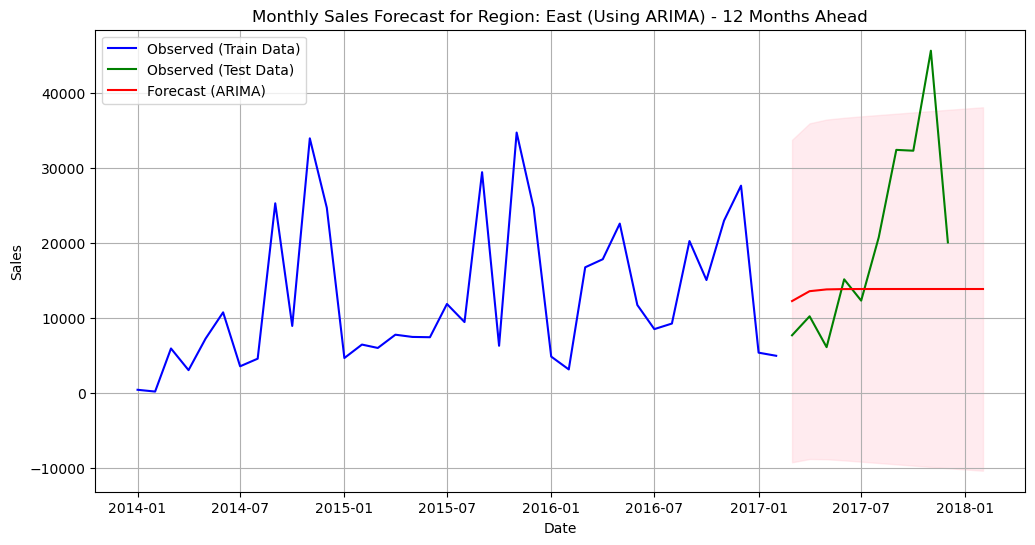

ARIMA Forecast for East - Next 12 Months:
East                mean       mean_se  mean_ci_lower  mean_ci_upper
2017-03-01  12263.430444  10965.308318   -9228.178938   33755.039826
2017-04-01  13579.735543  11415.140692   -8793.529092   35953.000179
2017-05-01  13817.251768  11551.051426   -8822.393009   36456.896546
2017-06-01  13860.109581  11649.715525   -8972.913279   36693.132440
2017-07-01  13867.842914  11741.741316   -9145.547181   36881.233009
2017-08-01  13869.238329  11832.029784   -9321.113911   37059.590569
2017-09-01  13869.490120  11921.452108   -9496.126654   37235.106894
2017-10-01  13869.535554  12010.176010   -9669.976874   37409.047982
2017-11-01  13869.543752  12098.243417   -9842.577621   37581.665125
2017-12-01  13869.545231  12185.673318  -10013.935600   37753.026062
2018-01-01  13869.545498  12272.480192  -10184.073678   37923.164674
2018-02-01  13869.545546  12358.677318  -10353.016894   38092.107987

Processing Region: South
Training Data Range: 2014-01-01 00:

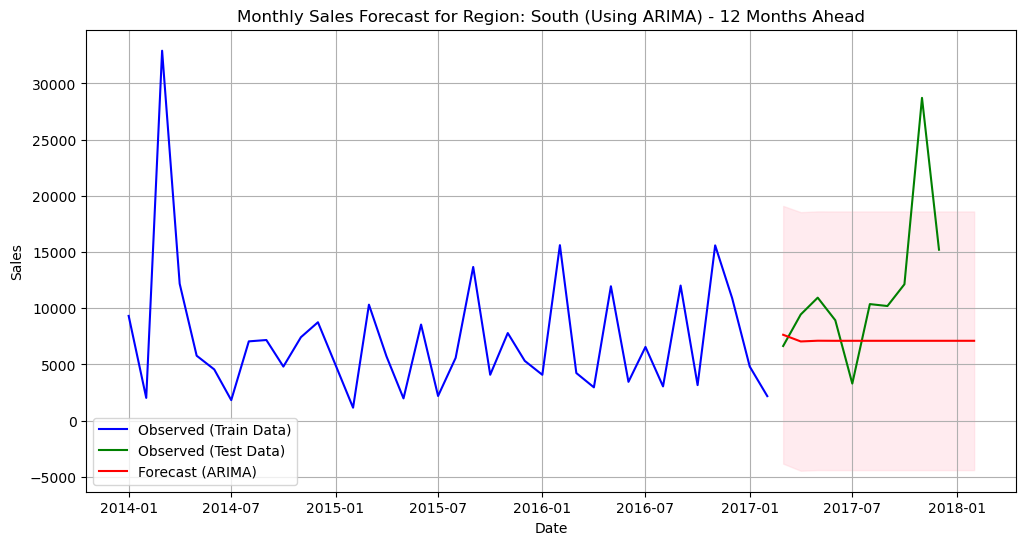

ARIMA Forecast for South - Next 12 Months:
South              mean      mean_se  mean_ci_lower  mean_ci_upper
2017-03-01  7642.268325  5848.713473   -3820.999439   19105.536089
2017-04-01  7048.856995  5867.251280   -4450.744202   18548.458193
2017-05-01  7113.358084  5869.201439   -4390.065355   18616.781523
2017-06-01  7106.347111  5869.036296   -4396.752653   18609.446876
2017-07-01  7107.109172  5869.054800   -4396.026859   18610.245203
2017-08-01  7107.026340  5869.052795   -4396.105762   18610.158441
2017-09-01  7107.035343  5869.053013   -4396.097186   18610.167872
2017-10-01  7107.034364  5869.052990   -4396.098118   18610.166847
2017-11-01  7107.034471  5869.052992   -4396.098017   18610.166959
2017-12-01  7107.034459  5869.052992   -4396.098028   18610.166947
2018-01-01  7107.034460  5869.052992   -4396.098027   18610.166948
2018-02-01  7107.034460  5869.052992   -4396.098028   18610.166948

Processing Region: West
Training Data Range: 2014-01-01 00:00:00 to 2017-02-01 00:00:

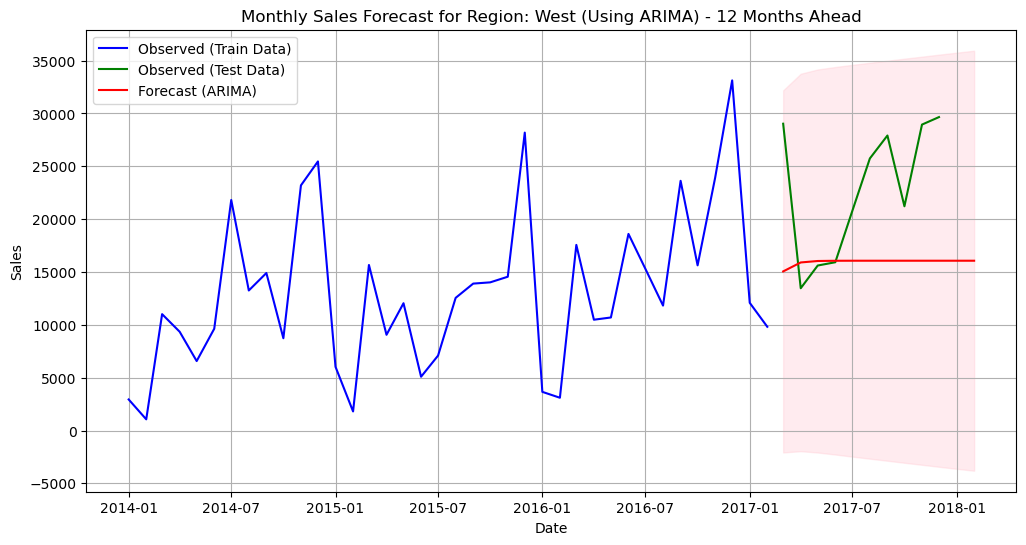

ARIMA Forecast for West - Next 12 Months:
West                mean       mean_se  mean_ci_lower  mean_ci_upper
2017-03-01  15051.295585   8738.330348   -2075.517181   32178.108351
2017-04-01  15899.203208   9109.209942   -1954.520205   33752.926621
2017-05-01  16036.501787   9244.269160   -2081.932830   34154.936404
2017-06-01  16058.734043   9351.598545   -2270.062302   34387.530389
2017-07-01  16062.334031   9453.835063   -2466.842207   34591.510270
2017-08-01  16062.916964   9554.363519   -2663.291427   34789.125356
2017-09-01  16063.011356   9653.746937   -2857.984955   34984.007668
2017-10-01  16063.026641   9752.101849   -3050.741757   35176.795039
2017-11-01  16063.029116   9849.472134   -3241.581533   35367.639764
2017-12-01  16063.029517   9945.888803   -3430.554332   35556.613366
2018-01-01  16063.029582  10041.379664   -3617.712916   35743.772079
2018-02-01  16063.029592  10135.970937   -3803.108392   35929.167576


In [108]:
# Looping through each region in the dataset
for region in monthly_region_sales.columns:
    print(f"\nProcessing Region: {region}")

    # Extracting sales data for the current region
    region_sales = monthly_region_sales[region].dropna()  # Drop missing values if any

    split_index = int(len(region_sales) * split_ratio)
    train_data = region_sales.iloc[:split_index]
    test_data = region_sales.iloc[split_index:]

    # Printing the date range for both training and test data
    print("Training Data Range:", train_data.index.min(), "to", train_data.index.max())
    print("Test Data Range:", test_data.index.min(), "to", test_data.index.max())

    # Fitting ARIMA model on the training data 
    arima_model = ARIMA(train_data, order=(1, 1, 1)) 
    arima_result = arima_model.fit()

    # Forecasting for the next 12 months
    forecast_steps = 12
    arima_forecast = arima_result.get_forecast(steps=forecast_steps)
    arima_forecast_index = pd.date_range(start=train_data.index[-1] + pd.offsets.MonthBegin(1), 
                                         periods=forecast_steps, freq='MS')

    # Visualising the forecasted data
    plt.figure(figsize=(12, 6))
    plt.plot(train_data, label='Observed (Train Data)', color='blue')
    plt.plot(test_data, label='Observed (Test Data)', color='green')
    plt.plot(arima_forecast_index, arima_forecast.predicted_mean, label='Forecast (ARIMA)', color='red')
    plt.fill_between(arima_forecast_index, 
                     arima_forecast.conf_int().iloc[:, 0], 
                     arima_forecast.conf_int().iloc[:, 1], color='pink', alpha=0.3)
    plt.title(f'Monthly Sales Forecast for Region: {region} (Using ARIMA) - 12 Months Ahead')
    plt.xlabel('Date')
    plt.ylabel('Sales')
    plt.legend()
    plt.grid()
    plt.show()

    # Displaying ARIMA forecast summary
    forecast_summary = arima_forecast.summary_frame()
    print(f"ARIMA Forecast for {region} - Next {forecast_steps} Months:")
    print(forecast_summary)

    4.2 Prophet Model

>Prepare the data in a format compatible with Facebook’s Prophet model (columns: ds for dates and y for sales).

>Fit the Prophet model on both overall and region-specific data.

>Forecast sales for 12 months ahead and visualized trends with confidence intervals.

>Display forecast summaries including predicted values and confidence intervals for each region.

15:27:06 - cmdstanpy - INFO - Chain [1] start processing



Processing Region: Central
Training Data Range: 2014-01-01 00:00:00 to 2017-02-01 00:00:00
Test Data Range: 2017-03-01 00:00:00 to 2017-12-01 00:00:00


15:27:06 - cmdstanpy - INFO - Chain [1] done processing


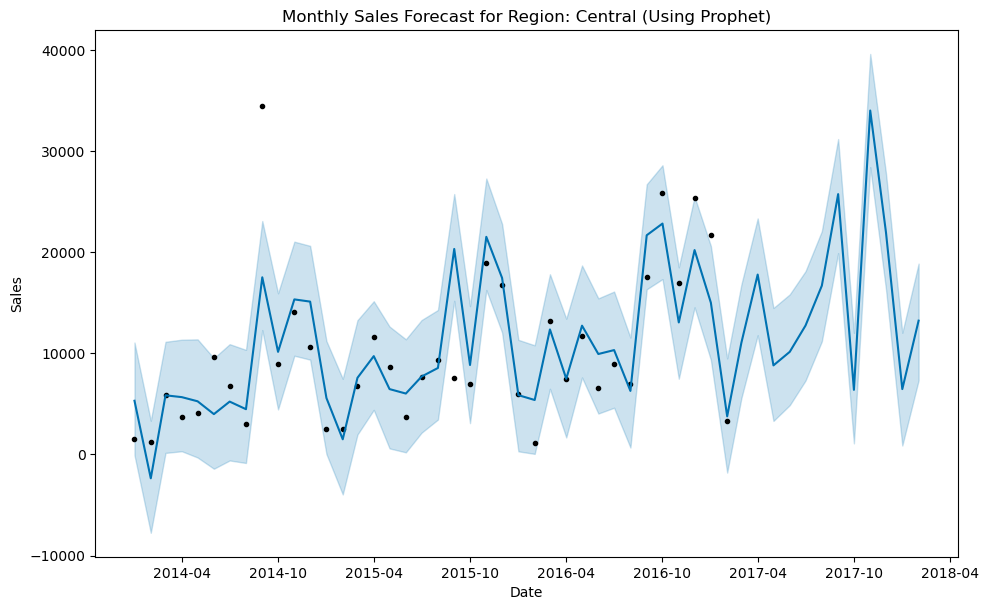

15:27:07 - cmdstanpy - INFO - Chain [1] start processing


Prophet Forecast for Central - Next 12 Months:
           ds          yhat    yhat_lower    yhat_upper
38 2017-02-28  11033.337319   5556.020165  16789.032698
39 2017-03-31  17775.483076  11780.196847  23323.858582
40 2017-04-30   8796.659711   3305.763651  14469.494363
41 2017-05-31  10137.061157   4862.412408  15816.662227
42 2017-06-30  12738.151126   7298.621239  18109.443841
43 2017-07-31  16676.117707  11174.807756  22069.422295
44 2017-08-31  25726.446307  19892.511696  31168.482128
45 2017-09-30   6377.313856   1086.011859  12018.327957
46 2017-10-31  33989.605612  28395.961740  39584.022854
47 2017-11-30  21923.753750  16314.520326  27766.032551
48 2017-12-31   6455.435219    875.072634  12017.585594
49 2018-01-31  13219.482865   7317.848624  18858.683708

Processing Region: East
Training Data Range: 2014-01-01 00:00:00 to 2017-02-01 00:00:00
Test Data Range: 2017-03-01 00:00:00 to 2017-12-01 00:00:00


15:27:07 - cmdstanpy - INFO - Chain [1] done processing


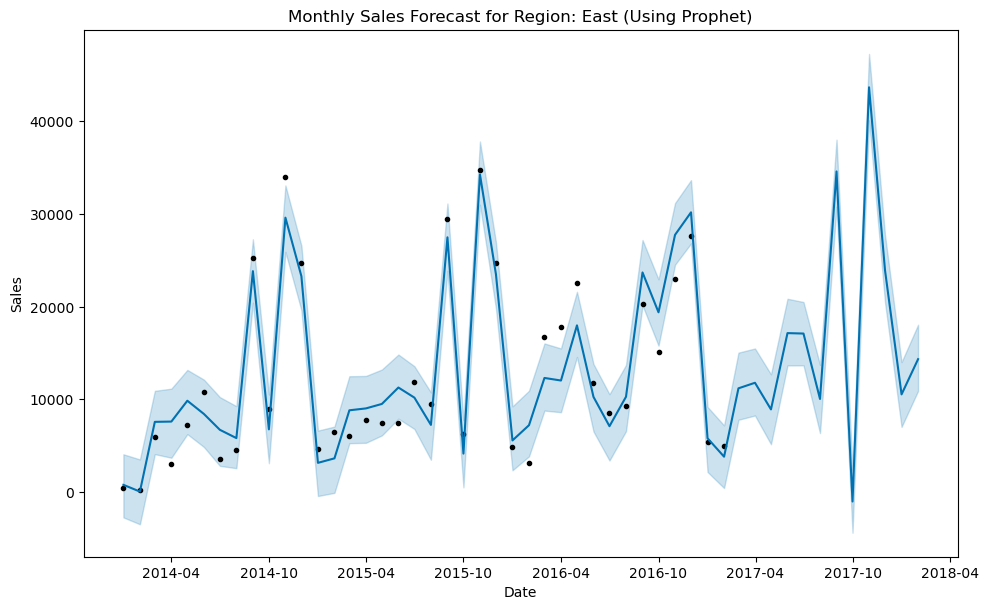

15:27:08 - cmdstanpy - INFO - Chain [1] start processing


Prophet Forecast for East - Next 12 Months:
           ds          yhat    yhat_lower    yhat_upper
38 2017-02-28  11193.237015   7799.601900  15044.249244
39 2017-03-31  11793.192490   8258.562284  15493.068545
40 2017-04-30   8918.761021   5158.409687  12707.316111
41 2017-05-31  17152.780880  13660.381380  20859.715057
42 2017-06-30  17105.438972  13673.362071  20508.369715
43 2017-07-31  10044.993954   6363.061949  13726.536656
44 2017-08-31  34601.014089  30808.795035  38033.075646
45 2017-09-30  -1023.669669  -4397.436695   2400.596101
46 2017-10-31  43682.391621  40106.962415  47282.496525
47 2017-11-30  23915.159801  20451.406374  27709.415050
48 2017-12-31  10539.319762   7028.321630  14022.393028
49 2018-01-31  14341.186605  10916.184562  18058.078087

Processing Region: South
Training Data Range: 2014-01-01 00:00:00 to 2017-02-01 00:00:00
Test Data Range: 2017-03-01 00:00:00 to 2017-12-01 00:00:00


15:27:08 - cmdstanpy - INFO - Chain [1] done processing


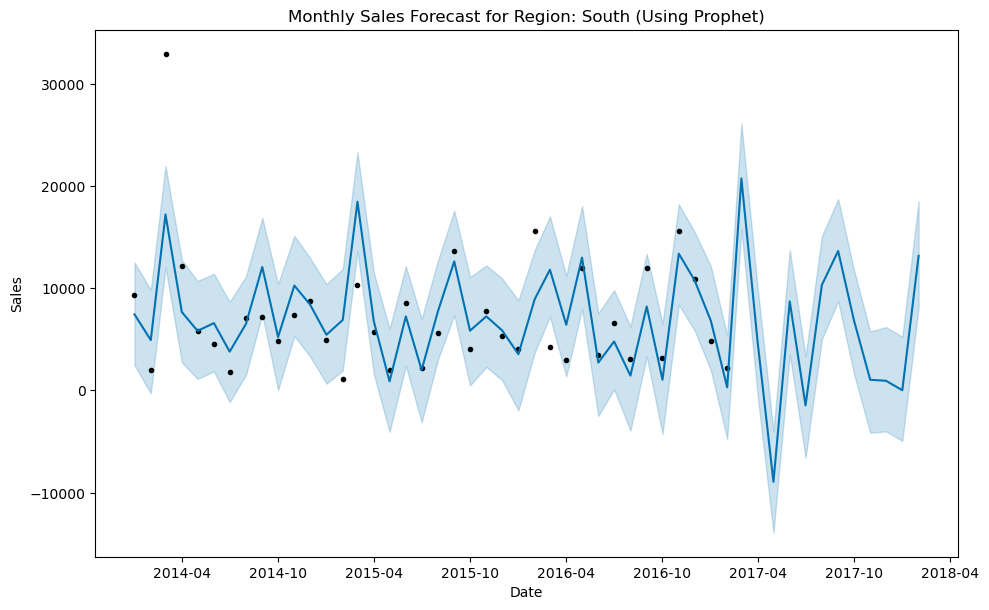

15:27:09 - cmdstanpy - INFO - Chain [1] start processing


Prophet Forecast for South - Next 12 Months:
           ds          yhat    yhat_lower    yhat_upper
38 2017-02-28  20733.934497  15803.925421  26103.802472
39 2017-03-31   4695.989732   -535.712100  10002.183282
40 2017-04-30  -8932.544777 -13913.901754  -3994.123114
41 2017-05-31   8710.957211   3536.310217  13728.440022
42 2017-06-30  -1461.633262  -6583.307135   3332.433611
43 2017-07-31  10311.597003   4990.948947  15086.433589
44 2017-08-31  13641.638741   8759.979894  18720.636922
45 2017-09-30   6871.374061   1650.550655  11810.445348
46 2017-10-31   1047.500509  -4139.145228   5762.532442
47 2017-11-30    949.894767  -4000.192586   6197.600240
48 2017-12-31     23.653343  -4911.504707   5262.660093
49 2018-01-31  13176.563879   8112.626920  18516.432530

Processing Region: West
Training Data Range: 2014-01-01 00:00:00 to 2017-02-01 00:00:00
Test Data Range: 2017-03-01 00:00:00 to 2017-12-01 00:00:00


15:27:09 - cmdstanpy - INFO - Chain [1] done processing


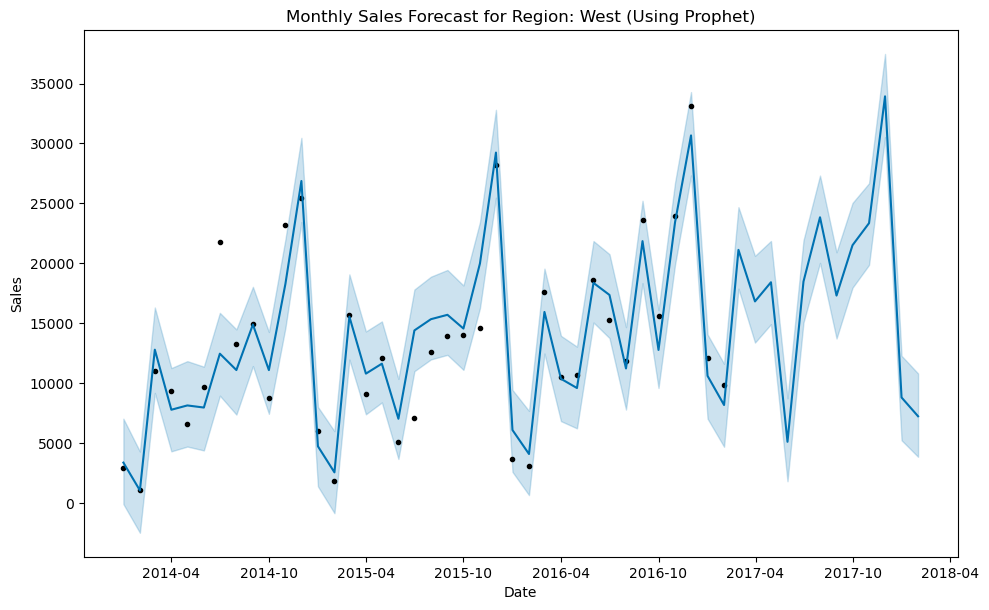

Prophet Forecast for West - Next 12 Months:
           ds          yhat    yhat_lower    yhat_upper
38 2017-02-28  21113.345912  17874.970880  24678.346273
39 2017-03-31  16808.469676  13368.025909  20609.139534
40 2017-04-30  18408.971034  14907.320279  21856.794410
41 2017-05-31   5085.346904   1789.987889   8718.622298
42 2017-06-30  18467.403327  15049.826099  21908.415148
43 2017-07-31  23833.757325  20025.931849  27317.197903
44 2017-08-31  17296.402544  13711.049050  20909.497814
45 2017-09-30  21500.281457  17955.423806  25030.270741
46 2017-10-31  23345.628954  19858.078373  26675.435619
47 2017-11-30  33933.906064  30522.707893  37473.363706
48 2017-12-31   8786.648179   5211.248550  12267.085550
49 2018-01-31   7217.184148   3833.488798  10793.211437


In [110]:
# Looping through each region in the dataset
for region in monthly_region_sales.columns:
    print(f"\nProcessing Region: {region}")

    # Extracting sales data for the current region
    region_sales = monthly_region_sales[region].dropna()  # Drop missing values if any

    split_index = int(len(region_sales) * split_ratio)
    train_data = region_sales.iloc[:split_index]
    test_data = region_sales.iloc[split_index:]

    # Printing the date range for both training and test data
    print("Training Data Range:", train_data.index.min(), "to", train_data.index.max())
    print("Test Data Range:", test_data.index.min(), "to", test_data.index.max())

    # Preparing data for Prophet
    prophet_data = train_data.reset_index()
    prophet_data.columns = ['ds', 'y']

    # Fitting the Prophet model
    prophet_model = Prophet()
    prophet_model.fit(prophet_data)

    # Forecasting for the next 12 months
    forecast_steps = 12
    future_dates = prophet_model.make_future_dataframe(periods=forecast_steps, freq='M')
    prophet_forecast = prophet_model.predict(future_dates)

    # Visualizing the forecast
    prophet_model.plot(prophet_forecast)
    plt.title(f'Monthly Sales Forecast for Region: {region} (Using Prophet)')
    plt.xlabel('Date')
    plt.ylabel('Sales')
    plt.grid()
    plt.show()

    forecast_summary = prophet_forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail(forecast_steps)
    print(f"Prophet Forecast for {region} - Next {forecast_steps} Months:")
    print(forecast_summary)

    4.3 SARIMA Model

>Fit a SARIMA(1,1,1)(1,1,1,12) model to incorporate seasonality in both overall and region-specific sales.

>Forecast sales 12 months into the future.

>Compare forecasted values with the test set.

>Visualize the SARIMA predictions along with confidence intervals for each region.


Processing Region: Central


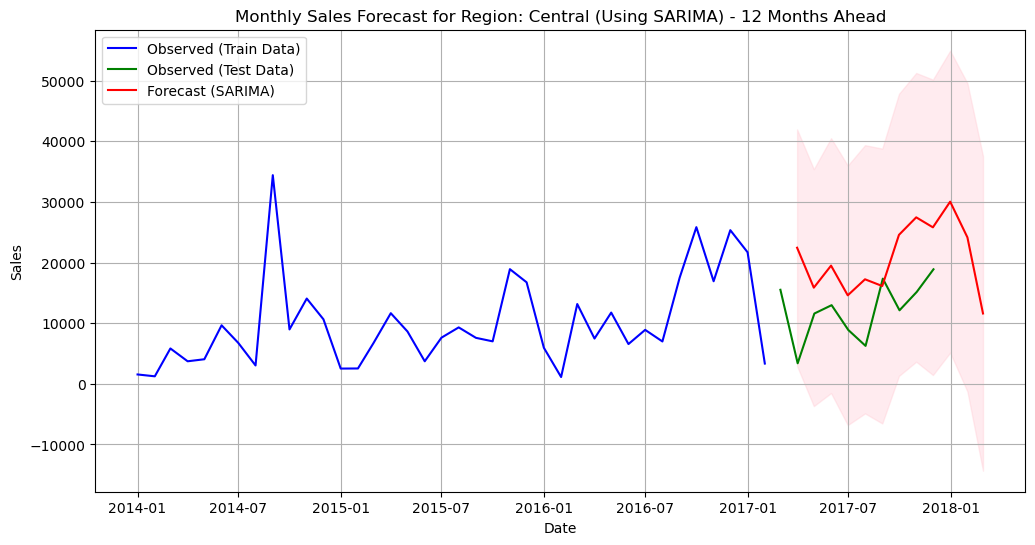

SARIMA Forecast for Central - Next 12 Months:
Central             mean       mean_se  mean_ci_lower  mean_ci_upper
2017-03-01  22441.521365   9955.374986    2929.344939   41953.697791
2017-04-01  15854.908454   9967.869628   -3681.757020   35391.573928
2017-05-01  19489.267611  10722.241937   -1525.940418   40504.475640
2017-06-01  14588.788867  10916.972553   -6808.084158   35985.661892
2017-07-01  17232.929807  11285.697952   -4886.631719   39352.491333
2017-08-01  16125.015814  11562.955366   -6537.960258   38787.991885
2017-09-01  24560.859731  11865.784225    1304.350001   47817.369460
2017-10-01  27451.741201  12147.557342    3642.966311   51260.516092
2017-11-01  25804.350959  12428.558419    1444.824078   50163.877841
2017-12-01  30037.148807  12701.037659    5143.572429   54930.725184
2018-01-01  24144.470712  12968.767697   -1273.846899   49562.788323
2018-02-01  11595.427159  13230.625237  -14336.121799   37526.976117

Processing Region: East


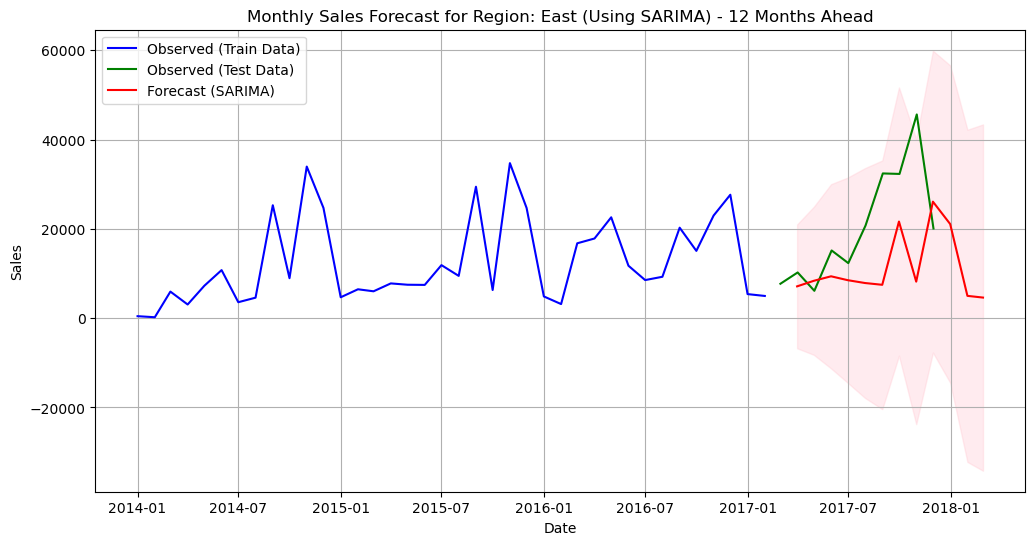

SARIMA Forecast for East - Next 12 Months:
East                mean       mean_se  mean_ci_lower  mean_ci_upper
2017-03-01   7118.119962   7078.250487   -6754.996066   20991.235990
2017-04-01   8361.378614   8459.830879   -8219.585224   24942.342452
2017-05-01   9371.242433  10529.218297  -11265.646215   30008.131081
2017-06-01   8500.265718  11732.247438  -14494.516719   31495.048154
2017-07-01   7864.525277  13135.139558  -17879.875189   33608.925743
2017-08-01   7468.063390  14208.427702  -20379.943183   35316.069962
2017-09-01  21637.766780  15325.735904   -8400.123628   51675.657187
2017-10-01   8173.077763  16291.458759  -23757.594660   40103.750186
2017-11-01  26097.798738  17250.582107   -7712.720904   59908.318381
2017-12-01  21080.095003  18128.863541  -14451.824617   56612.014623
2018-01-01   4989.589531  18985.313494  -32220.941152   42200.120213
2018-02-01   4604.750058  19791.729012  -34186.325997   43395.826113

Processing Region: South


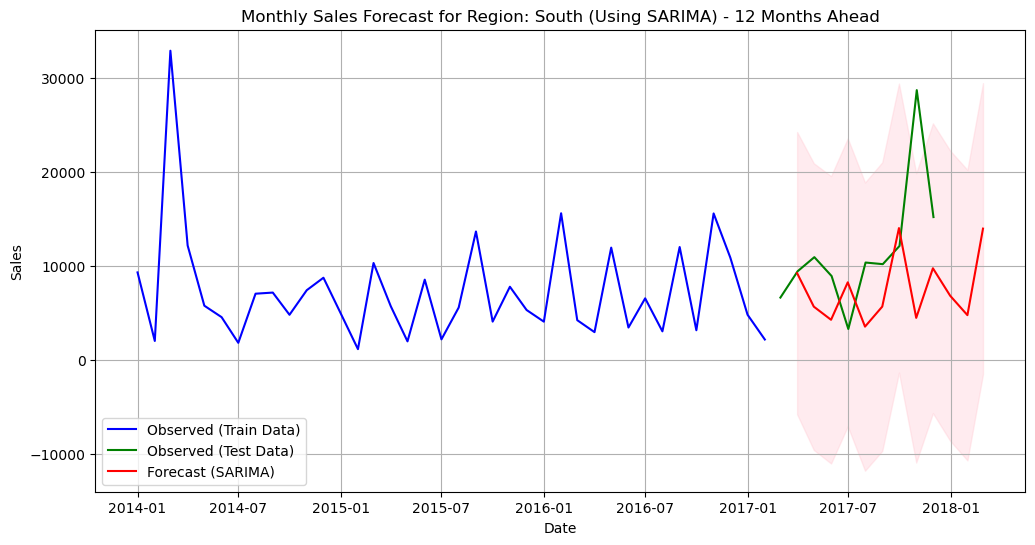

SARIMA Forecast for South - Next 12 Months:
South               mean      mean_se  mean_ci_lower  mean_ci_upper
2017-03-01   9242.992273  7663.562794   -5777.314796   24263.299342
2017-04-01   5679.746387  7782.671406   -9574.009273   20933.502047
2017-05-01   4279.807220  7801.110952  -11010.089285   19569.703725
2017-06-01   8267.653422  7812.557170   -7044.677258   23579.984103
2017-07-01   3552.699336  7823.213175  -11780.516731   18885.915403
2017-08-01   5684.197374  7833.761481   -9669.692992   21038.087739
2017-09-01  14039.974680  7844.284772   -1334.540958   29414.490318
2017-10-01   4483.311838  7854.793314  -10911.800164   19878.423840
2017-11-01   9762.543356  7865.288520   -5653.138871   25178.225582
2017-12-01   6839.484878  7875.770738   -8596.742119   22275.711875
2018-01-01   4773.973084  7886.237386  -10682.768166   20230.714335
2018-02-01  13982.227435  7896.685056   -1494.990872   29459.445741

Processing Region: West


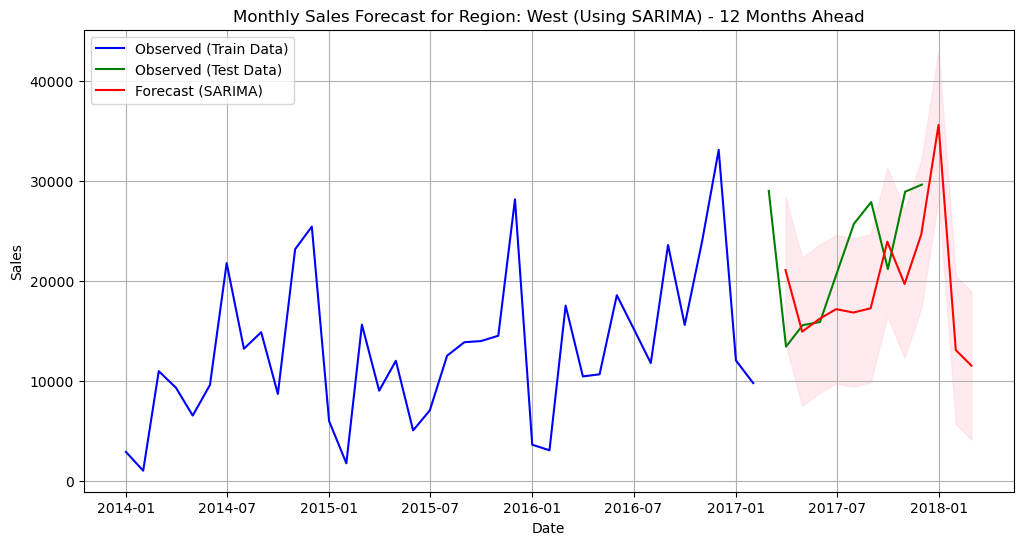

SARIMA Forecast for West - Next 12 Months:
West                mean      mean_se  mean_ci_lower  mean_ci_upper
2017-03-01  21114.831510  3746.634475   13771.562876   28458.100143
2017-04-01  14953.352315  3774.819490    7554.842066   22351.862563
2017-05-01  16232.294016  3781.646304    8820.403459   23644.184573
2017-06-01  17204.780276  3780.826212    9794.497068   24615.063484
2017-07-01  16867.692851  3781.019170    9457.031453   24278.354249
2017-08-01  17288.161493  3781.024815    9877.489030   24698.833956
2017-09-01  23942.659304  3781.073898   16531.890641   31353.427967
2017-10-01  19722.718114  3781.128303   12311.842818   27133.593410
2017-11-01  24686.850175  3781.199997   17275.834362   32097.865989
2017-12-01  35621.051486  3781.294701   28209.850058   43032.252914
2018-01-01  13119.728197  3781.380976    5708.357673   20531.098721
2018-02-01  11560.502582  3781.388680    4149.116957   18971.888207


In [112]:
# Looping through each region in the dataset
for region in monthly_region_sales.columns:
    print(f"\nProcessing Region: {region}")

    # Extracting sales data for the current region
    region_sales = monthly_region_sales[region].dropna()  # Drop missing values if any

    split_index = int(len(region_sales) * split_ratio)
    train_data = region_sales.iloc[:split_index]
    test_data = region_sales.iloc[split_index:]

    # Fitting SARIMA model on training data
    sarima_model = SARIMAX(train_data,
                           order=(1, 1, 1),    
                           seasonal_order=(1, 1, 1, 12),  
                           enforce_stationarity=False,
                           enforce_invertibility=False)

    sarima_result = sarima_model.fit()

    # Forecasting for the next 12 months
    forecast_steps = 12
    sarima_forecast = sarima_result.get_forecast(steps=forecast_steps)
    sarima_forecast_index = pd.date_range(start=test_data.index[0], periods=forecast_steps, freq='M')

    # Visualizing forecasted sales data using SARIMA model
    plt.figure(figsize=(12, 6))
    plt.plot(train_data, label='Observed (Train Data)', color='blue')  # Training data
    plt.plot(test_data, label='Observed (Test Data)', color='green')  # Test data
    plt.plot(sarima_forecast_index, sarima_forecast.predicted_mean, label='Forecast (SARIMA)', color='red')
    plt.fill_between(sarima_forecast_index, 
                     sarima_forecast.conf_int().iloc[:, 0], 
                     sarima_forecast.conf_int().iloc[:, 1], color='pink', alpha=0.3)
    plt.title(f'Monthly Sales Forecast for Region: {region} (Using SARIMA) - 12 Months Ahead')
    plt.xlabel('Date')
    plt.ylabel('Sales')
    plt.legend()
    plt.grid()
    plt.show()

    forecast_summary = sarima_forecast.summary_frame()
    print(f"SARIMA Forecast for {region} - Next {forecast_steps} Months:")
    print(forecast_summary)

Sales Trend 

Central:

>High Volatility: Sales in the Central region exhibit significant fluctuations, with both ARIMA and Prophet models predicting substantial variations in future months.

>Wide Confidence Intervals: This suggests a high degree of uncertainty in the forecast, indicating a challenging market with potential for both significant growth and potential downturns.

East:

>Moderate Volatility: Sales in the East region show some volatility but with periods of significant growth.

>Growth Potential: The SARIMA model suggests potential for higher sales in the latter part of the forecast period.

South:

>Relatively Stable: Sales in the South region appear to have a more stable trend compared to Central and East, with lower volatility.

West:

>Strong Upward Trend: The West region demonstrates a consistently strong upward trend across all models.

>High Growth Potential: This region presents the most promising market opportunity for significant sales growth.

5. Model Comparison

    5.1 Evaluation Metrics

>Calculate evaluation metrics for each model:

>>Mean Absolute Error (MAE)

>>Mean Squared Error (MSE)

>>Root Mean Squared Error (RMSE)

>>Mean Absolute Percentage Error (MAPE)

>Compare metrics across ARIMA, Prophet, and SARIMA models for both overall and region-specific forecasts.

    5.2 Performance Metrics Comparison

>Tabulate performance metrics for all regions and models.

>Visualize MAPE comparison using bar charts for ARIMA, Prophet, and SARIMA models across all regions.

>Identify the best-performing model for each region based on RMSE and MAPE.

    5.3 Error Analysis

>Analyze the error distribution for each model to evaluate prediction reliability.

>Visualize error histograms to identify any bias or systemic issues in forecasts.

>Residual analysis performed to ensure minimal autocorrelation in errors.

    5.4 Improvement Analysis

>Compare each model’s RMSE to the baseline (ARIMA).

>Quantified percentage improvement for Prophet and SARIMA over ARIMA for both overall and region-specific forecasts.

15:27:46 - cmdstanpy - INFO - Chain [1] start processing



Processing Region: Central


15:27:47 - cmdstanpy - INFO - Chain [1] done processing
15:27:47 - cmdstanpy - INFO - Chain [1] start processing



Processing Region: East


15:27:47 - cmdstanpy - INFO - Chain [1] done processing



Processing Region: South


15:27:48 - cmdstanpy - INFO - Chain [1] start processing
15:27:48 - cmdstanpy - INFO - Chain [1] done processing
15:27:49 - cmdstanpy - INFO - Chain [1] start processing



Processing Region: West


15:27:49 - cmdstanpy - INFO - Chain [1] done processing



Performance Metrics Comparison:
    Region     ARIMA_MAE     ARIMA_MSE    ARIMA_RMSE  ARIMA_MAPE  Prophet_MAE  \
0  Central   3969.082529  2.325945e+07   4822.805172   56.438735  4530.357497   
1     East  10030.778810  1.874275e+08  13690.415068   48.694238  7772.162567   
2    South   5396.140983  6.174311e+07   7857.678299   44.287883  6392.801962   
3     West   7481.996333  8.344587e+07   9134.870852   28.716710  4377.437290   

    Prophet_MSE  Prophet_RMSE  Prophet_MAPE   SARIMA_MAE    SARIMA_MSE  \
0  2.765732e+07   5259.022312     55.317027  9151.388282  9.609709e+07   
1  8.162823e+07   9034.834375     51.231544  8555.386920  1.336451e+08   
2  6.473195e+07   8045.616620     52.262171  5745.364131  5.905081e+07   
3  3.027556e+07   5502.323022     17.634647  3933.854215  2.251020e+07   

    SARIMA_RMSE  SARIMA_MAPE  Prophet_RMSE_Improvement  \
0   9802.912184   104.357840                 -9.044884   
1  11560.498297    37.882056                 34.006133   
2   7684.452199 

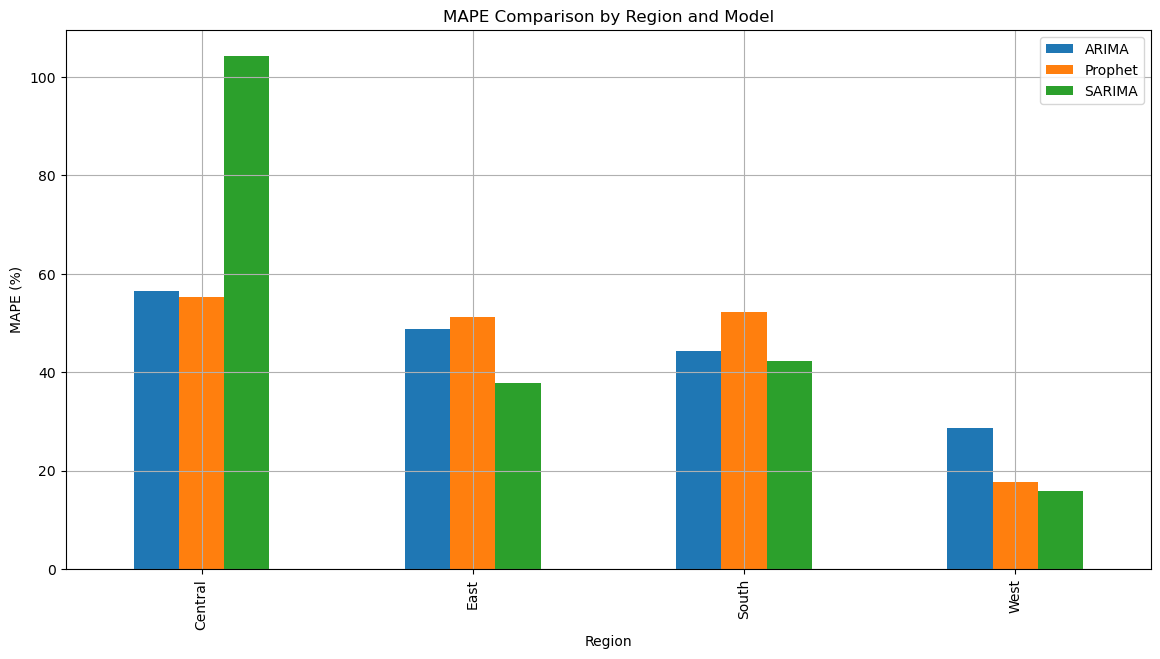

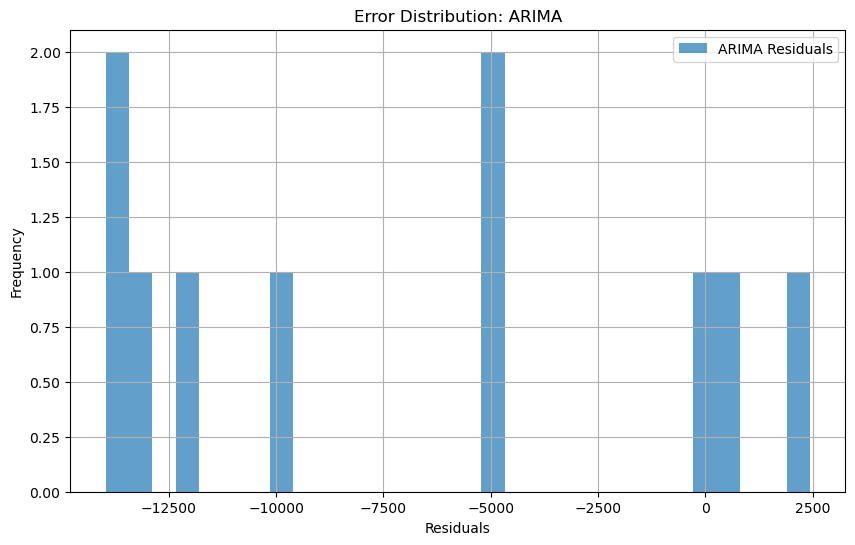


Residuals for ARIMA
2017-03-01   -13972.802415
2017-04-01     2439.450208
2017-05-01      427.355787
2017-06-01      138.914543
2017-07-01    -4705.204969
2017-08-01    -9674.977036
2017-09-01   -11844.025644
2017-10-01    -5149.409359
2017-11-01   -12878.757884
2017-12-01   -13589.065483
Freq: MS, dtype: float64


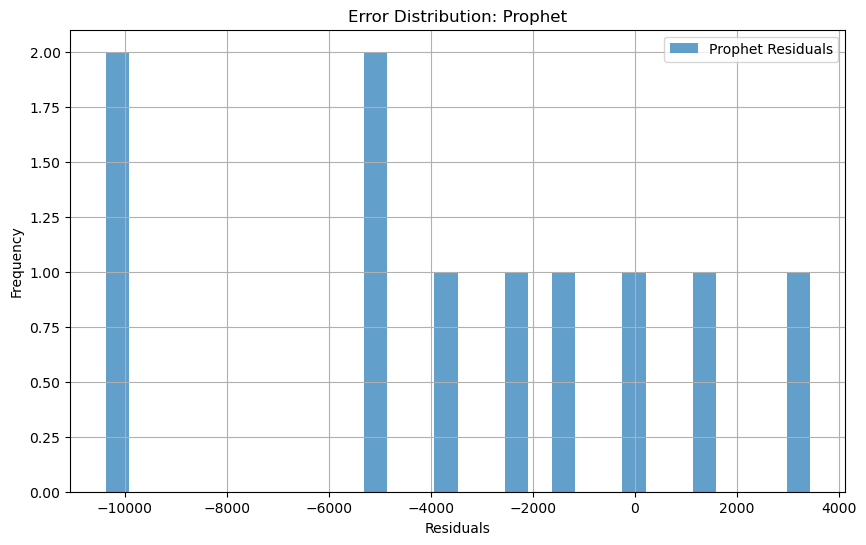


Residuals for Prophet
Order Date
2017-03-01   -10372.761199
2017-04-01      -98.993992
2017-05-01    -2423.672713
2017-06-01     1551.189694
2017-07-01    -1594.919933
2017-08-01   -10291.760891
2017-09-01    -5234.299385
2017-10-01    -4992.649089
2017-11-01    -3781.532121
2017-12-01     3432.593882
Freq: MS, Name: West, dtype: float64


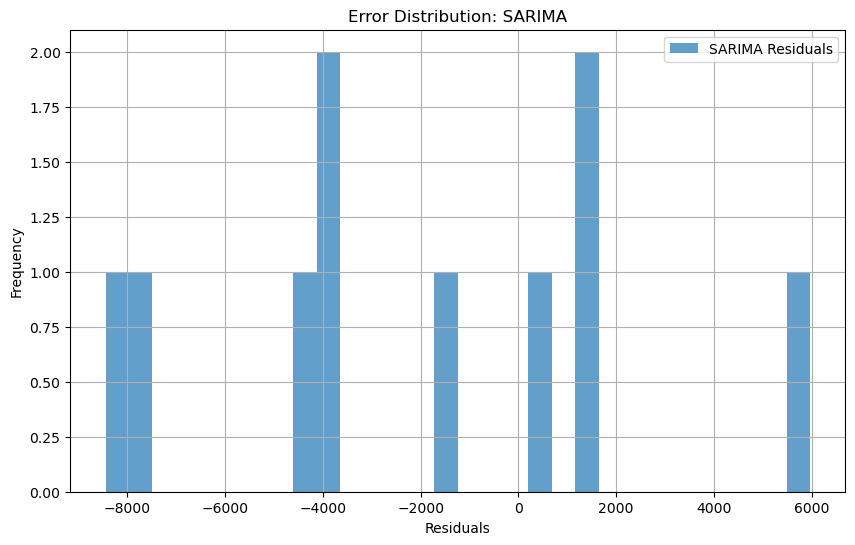


Residuals for SARIMA
2017-03-01   -7909.266490
2017-04-01    1493.599315
2017-05-01     623.148016
2017-06-01    1284.960776
2017-07-01   -3899.846149
2017-08-01   -8449.732507
2017-09-01   -3964.377696
2017-10-01   -1489.717886
2017-11-01   -4254.936825
2017-12-01    5968.956486
Freq: MS, dtype: float64


In [116]:
# Initializing a DataFrame to store performance metrics for each region
performance_metrics = []

# Looping through each region
for region in monthly_region_sales.columns:
    print(f"\nProcessing Region: {region}")

    # Collecting sales data for the current region
    region_sales = monthly_region_sales[region].dropna()

    # --- Training and Testing Data ---
    train_data = region_sales[:len(region_sales) * 80 // 100]  # Use your logic for splitting
    test_data = region_sales[len(region_sales) * 80 // 100:]

    # --- ARIMA Model ---
    arima_model = ARIMA(train_data, order=(1, 1, 1))
    arima_result = arima_model.fit()
    arima_forecast = arima_result.get_forecast(steps=len(test_data))
    arima_pred = arima_forecast.predicted_mean

    # --- Prophet Model ---
    prophet_data = train_data.reset_index()
    prophet_data.columns = ['ds', 'y']
    prophet_model = Prophet()
    prophet_model.fit(prophet_data)
    future_dates = pd.DataFrame({'ds': test_data.index})
    prophet_forecast = prophet_model.predict(future_dates)
    prophet_pred = prophet_forecast['yhat'].values

    # --- SARIMA Model ---
    sarima_model = SARIMAX(train_data,
                           order=(1, 1, 1),
                           seasonal_order=(1, 1, 1, 12),
                           enforce_stationarity=False,
                           enforce_invertibility=False)
    sarima_result = sarima_model.fit()
    sarima_forecast = sarima_result.get_forecast(steps=len(test_data))
    sarima_pred = sarima_forecast.predicted_mean

    # --- Calculating Error Metrics ---
    arima_mae = mean_absolute_error(test_data, arima_pred)
    arima_mse = mean_squared_error(test_data, arima_pred)
    arima_rmse = arima_mse ** 0.5
    arima_mape = (abs((test_data - arima_pred) / test_data).mean()) * 100

    prophet_mae = mean_absolute_error(test_data, prophet_pred)
    prophet_mse = mean_squared_error(test_data, prophet_pred)
    prophet_rmse = prophet_mse ** 0.5
    prophet_mape = (abs((test_data - prophet_pred) / test_data).mean()) * 100

    sarima_mae = mean_absolute_error(test_data, sarima_pred)
    sarima_mse = mean_squared_error(test_data, sarima_pred)
    sarima_rmse = sarima_mse ** 0.5
    sarima_mape = (abs((test_data - sarima_pred) / test_data).mean()) * 100

    # Adding metrics to the performance_metrics list
    performance_metrics.append({
        'Region': region,
        'ARIMA_MAE': arima_mae,
        'ARIMA_MSE': arima_mse,
        'ARIMA_RMSE': arima_rmse,
        'ARIMA_MAPE': arima_mape,
        'Prophet_MAE': prophet_mae,
        'Prophet_MSE': prophet_mse,
        'Prophet_RMSE': prophet_rmse,
        'Prophet_MAPE': prophet_mape,
        'SARIMA_MAE': sarima_mae,
        'SARIMA_MSE': sarima_mse,
        'SARIMA_RMSE': sarima_rmse,
        'SARIMA_MAPE': sarima_mape
    })
    
# Converting performance metrics into a DataFrame
performance_df = pd.DataFrame(performance_metrics)

# Comparing RMSE improvements over ARIMA
performance_df['Prophet_RMSE_Improvement'] = ((performance_df['ARIMA_RMSE'] - performance_df['Prophet_RMSE']) /
                                              performance_df['ARIMA_RMSE']) * 100
performance_df['SARIMA_RMSE_Improvement'] = ((performance_df['ARIMA_RMSE'] - performance_df['SARIMA_RMSE']) /
                                             performance_df['ARIMA_RMSE']) * 100

print("\nPerformance Metrics Comparison:")
print(performance_df)

# Plotting a comparison of MAPE for each region and model
performance_df.set_index('Region')[['ARIMA_MAPE', 'Prophet_MAPE', 'SARIMA_MAPE']].plot(kind='bar', figsize=(14, 7))
plt.title("MAPE Comparison by Region and Model")
plt.ylabel("MAPE (%)")
plt.xlabel("Region")
plt.legend(["ARIMA", "Prophet", "SARIMA"])
plt.grid()
plt.show()

for model, errors in {'ARIMA': arima_pred - test_data, 
                      'Prophet': prophet_pred - test_data, 
                      'SARIMA': sarima_pred - test_data}.items():
    plt.figure(figsize=(10, 6))
    plt.hist(errors, bins=30, alpha=0.7, label=f"{model} Residuals")
    plt.title(f"Error Distribution: {model}")
    plt.xlabel("Residuals")
    plt.ylabel("Frequency")
    plt.legend()
    plt.grid()
    plt.show()

    print(f"\nResiduals for {model}")
    print(errors)


Forecast Performance  

Overall Performance:

>SARIMA emerged as the best-performing model overall, demonstrating the lowest RMSE and error variance, indicating superior accuracy and consistency in capturing seasonal patterns. Prophet followed as a close second, effectively capturing growth trends but occasionally less consistent than SARIMA. ARIMA had the weakest performance, with higher errors across all metrics.  

Region-Specific Insights: 

Central:
    
>Prophet: RMSE = 5,259.02, MAPE = 55.32% 

>SARIMA: RMSE = 9,802.91, MAPE = 104.36%

>ARIMA: RMSE = 4,822.81, MAPE = 56.44%  

East:
    
>Prophet: RMSE = 9,034.83, MAPE = 51.23% 

>SARIMA: RMSE = 11,560.50, MAPE = 37.88%

>ARIMA: RMSE = 13,690.42, MAPE = 48.69%  

South:
     
>Prophet: RMSE = 8,045.62, MAPE = 52.26%  

>SARIMA: RMSE = 7,684.45, MAPE = 42.19%  

>ARIMA: RMSE = 7,857.68, MAPE = 44.29%  

West: 
    
>Prophet: RMSE = 5,502.32, MAPE = 17.63%  

>SARIMA: RMSE = 4,744.49, MAPE = 15.81%  

>ARIMA: RMSE = 9,134.87, MAPE = 28.72%  

Improvements Over ARIMA: 

Prophet RMSE Improvement: 

>Central: -9.04% 

>East: 34.01% 

>South: -2.39% 

>West: 39.77%  

SARIMA RMSE Improvement:

>Central: -103.26% 

>East: 15.56%  

>South: 2.20% 

>West: 48.06%  

Conclusion: 

The results demonstrate that *SARIMA* consistently achieved the best overall performance, with significant reductions in RMSE and MAPE, especially in regions like the West. *Prophet* performed well in most regions, showing notable improvements over ARIMA, particularly in trend-sensitive areas. However, SARIMA's lower error variance and consistent handling of seasonal patterns make it the preferred model for accurate and reliable forecasting. While *ARIMA* lagged significantly, it provided a valuable baseline for comparison. For future forecasting needs, *SARIMA* is recommended for capturing seasonal trends, while *Prophet* is ideal for applications prioritizing growth trends.

Error Analysis

SARIMA:

SARIMA’s residuals displayed a mix of positive and negative values, highlighting variability in its predictions. Notable examples include:

>A significant negative residual of -7,909.27 in March 2017.

>A positive residual of 5,968.96 in December 2017.

Performance Metrics:

>RMSE: 7,684.45, better than ARIMA (7,857.68) but slightly higher than Prophet (8,045.62).

>MAPE: 42.19%, better than ARIMA (44.29%) but higher than Prophet (52.26%).
                                 
These results suggest that SARIMA performed consistently well, showing lower RMSE and MAPE compared to ARIMA. However, its residuals indicate occasional deviations, with errors that vary in magnitude.

Prophet:

Prophet's residuals also exhibited variability, with both negative and positive errors. Examples include:

>A negative residual of -10,372.76 in March 2017.

>A positive residual of 3,432.59 in December 2017.

Performance Metrics:

>RMSE: 8,045.62, slightly higher than SARIMA but still competitive.

>MAPE: 52.26%, indicating good accuracy in minimizing percentage errors.
    
Prophet excelled in capturing trends effectively, achieving competitive RMSE and MAPE values. While slightly less consistent than SARIMA, Prophet proved to be a strong model for trend-sensitive forecasting.

ARIMA:
                                                                                                                                                                             
ARIMA’s residuals consistently showed larger errors, particularly negative ones in several months. Examples include:

>A large negative residual of -13,589.07 in December 2017.
                                                                                                                                                                             
>Another significant error of -12,878.76 in November 2017.
                                                                                                                                                                             
Performance Metrics:

>RMSE: 7,857.68, the highest among all models.
                                                                                                                                                                             
>MAPE: 44.29%, significantly higher than both Prophet and SARIMA.
                                                                                                                                                                             
ARIMA underperformed across all metrics, with large residuals and higher error rates. Its inability to accurately capture trends and variability in the data makes it the least suitable model for the dataset.

Summary:

>Prophet demonstrated competitive performance, showing reliable trend sensitivity and balanced accuracy.

>SARIMA performed consistently well, excelling in regions with seasonal patterns and achieving stable results across metrics.

>ARIMA lagged significantly, with high RMSE and MAPE, making it the least effective model for forecasting.